# CHIPS-CVN Evaluation

In [1]:
# The configuration yaml's must be specified
b_config_file = "./config/eval_beam.yml"
u_config_file = "./config/eval_uniform.yml"

In [2]:
# Import all the required modules and call the gpu_setup utility
import time
from array import array
import os
import ast
import importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import ROOT
from root_numpy import fill_hist
import mplhep as hep

import chipscvn.utils as utils
import chipscvn.config as config
import chipscvn.data as data
import chipscvn.models as models
import chipscvn.evaluators as evaluators
import chipscvn.explain 
utils.gpu_setup()  # Setup the GPU's
ROOT.gStyle.SetOptStat(0)

/mnt/storage/jtingey/chips-cvn/env/miniconda/envs/chips-cvn/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Welcome to JupyROOT 6.18/04
---  4 Physical GPUs, 4 Logical GPUs ---


In [3]:
# Run evaluation of both the 'beam' and 'uniform' datasets. This will take some time
print(" *** Beam Sample Evaluation ***\n")
b_conf = config.get(b_config_file)
b_eval = utils.get_evaluator(b_conf)
b_eval.run()

print(" *** Uniform Sample Evaluation ***\n")
u_conf = config.get(u_config_file)
u_eval = utils.get_evaluator(u_conf)
u_eval.run()

 *** Beam Sample Evaluation ***

--- Running Evaluation ---

--- running inference...

--- parsing outputs...

--- calculating weights...

Total-> Nuel: 21027, Numu: 21084, Cosmic: 21889

Weights-> Nuel:0.0038, Numu:0.1617, Cosmic:55.3108

--- calculating cuts...

--- Done (took 306.50492906570435 seconds) ---

 *** Uniform Sample Evaluation ***

--- Running Evaluation ---

--- running inference...

--- parsing outputs...

--- calculating weights...

Total-> Nuel: 27192, Numu: 27213, Cosmic: 9595

Weights-> Nuel:0.0029, Numu:0.1253, Cosmic:126.1801

--- calculating cuts...

--- Done (took 304.67801570892334 seconds) ---



2020-03-26 16:18:21.070151: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-03-26 16:18:21.350645: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


## Beam vs Uniform Sample

How do the samples differ?

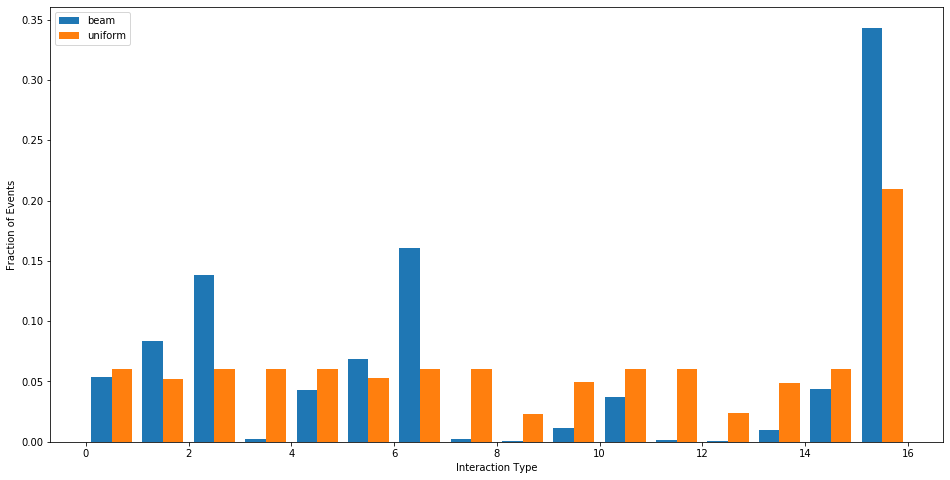

In [4]:
plt.figure(figsize=(16,8))
plt.hist([b_eval.events["t_cat"], u_eval.events["t_cat"]], bins=16, normed=True); plt.xlabel('Interaction Type'); plt.ylabel('Fraction of Events'); plt.legend(['beam', 'uniform']);
plt.show()

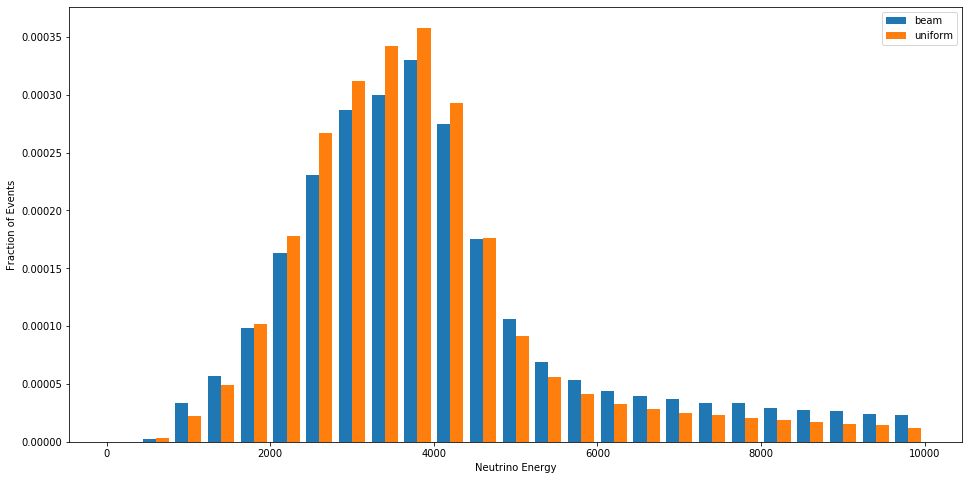

In [5]:
plt.figure(figsize=(16,8))
plt.hist([b_eval.events["t_nuEnergy"], u_eval.events["t_nuEnergy"]], bins=25, range=[0, 10000], normed=True); plt.xlabel('Neutrino Energy'); plt.ylabel('Fraction of Events'); plt.legend(['beam', 'uniform']);
plt.show()

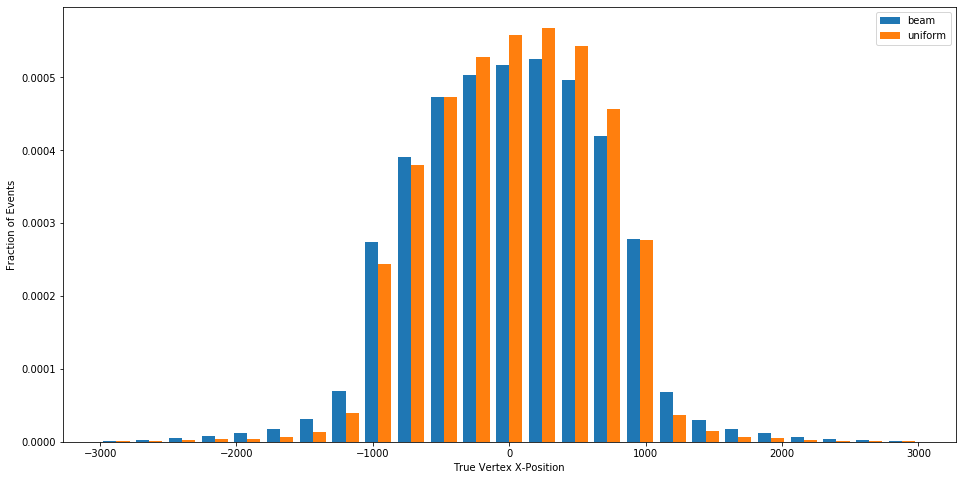

In [6]:
plt.figure(figsize=(16,8))
plt.hist([b_eval.events["t_vtxX"], u_eval.events["t_vtxX"]], bins=25, range=[-3000, 3000], normed=True); plt.xlabel('True Vertex X-Position'); plt.ylabel('Fraction of Events'); plt.legend(['beam', 'uniform']);
plt.show()

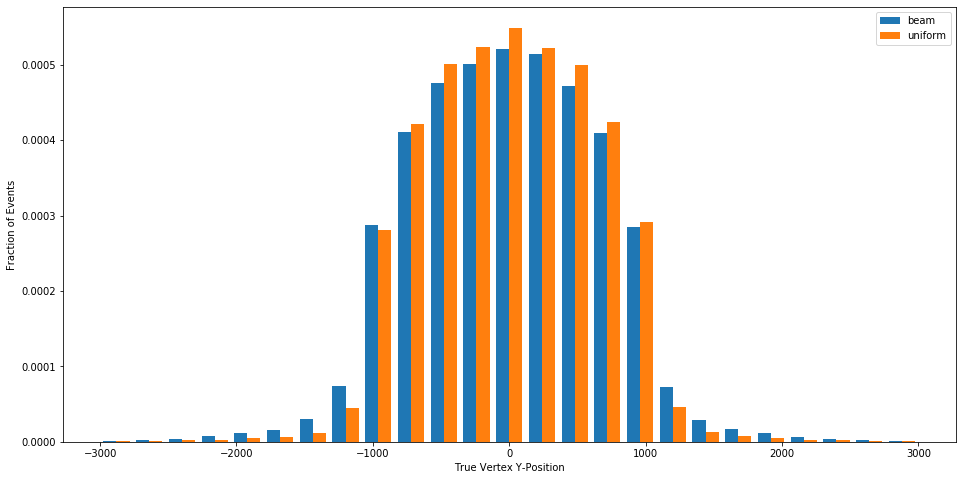

In [7]:
plt.figure(figsize=(16,8))
plt.hist([b_eval.events["t_vtxY"], u_eval.events["t_vtxY"]], bins=25, range=[-3000, 3000], normed=True); plt.xlabel('True Vertex Y-Position'); plt.ylabel('Fraction of Events'); plt.legend(['beam', 'uniform']);
plt.show()

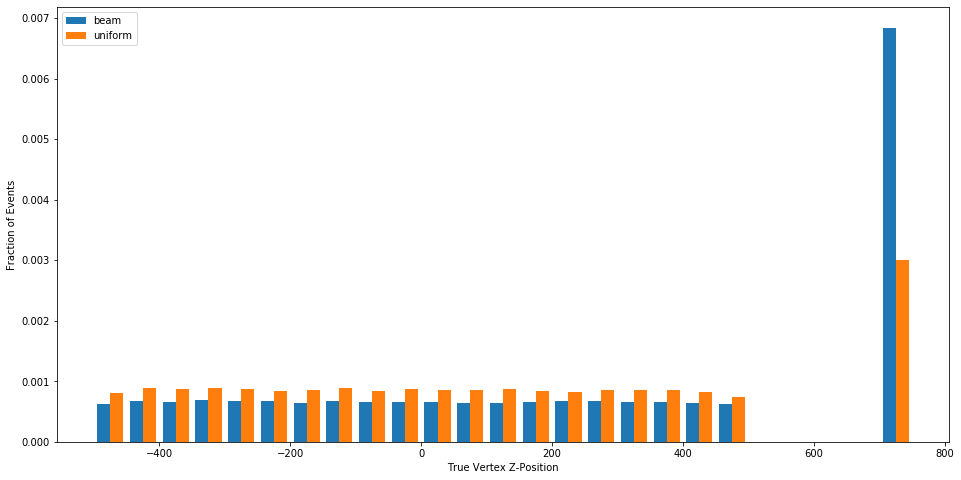

In [8]:
plt.figure(figsize=(16,8))
plt.hist([b_eval.events["t_vtxZ"], u_eval.events["t_vtxZ"]], bins=25, range=[-500, 750], normed=True); plt.xlabel('True Vertex Z-Position'); plt.ylabel('Fraction of Events'); plt.legend(['beam', 'uniform']);
plt.show()

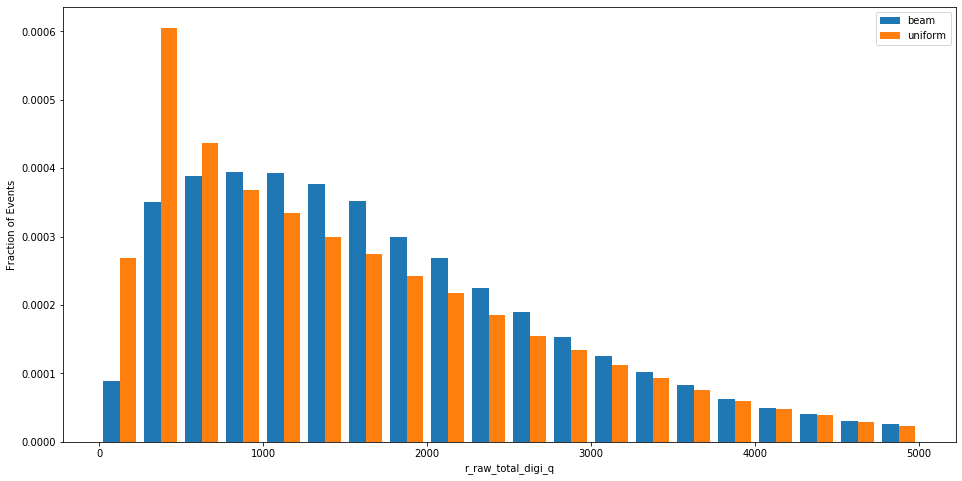

In [9]:
plt.figure(figsize=(16,8))
plt.hist([b_eval.events["r_raw_total_digi_q"], u_eval.events["r_raw_total_digi_q"]], bins=20, range=[0, 5000], normed=True); plt.xlabel('r_raw_total_digi_q'); plt.ylabel('Fraction of Events'); plt.legend(['beam', 'uniform']);
plt.show()

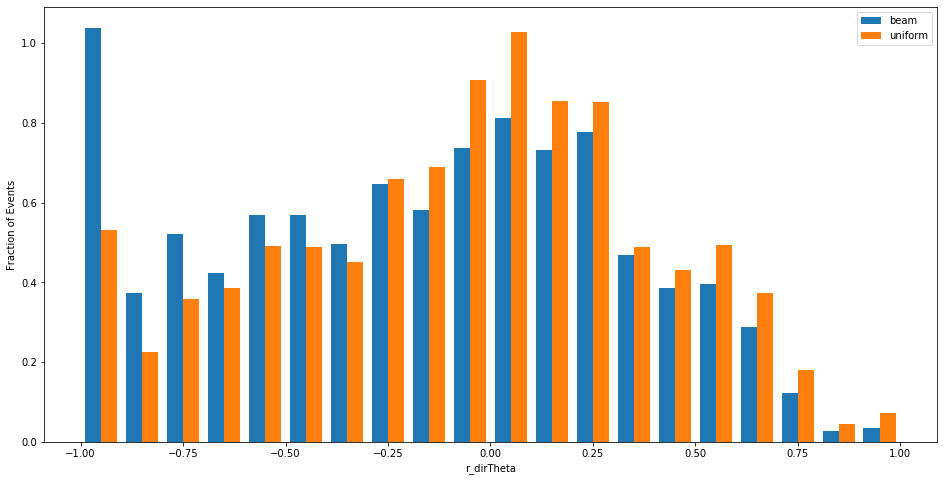

In [10]:
plt.figure(figsize=(16,8))
plt.hist([b_eval.events["r_dirTheta"], u_eval.events["r_dirTheta"]], bins=20, range=[-1, 1], normed=True); plt.xlabel('r_dirTheta'); plt.ylabel('Fraction of Events'); plt.legend(['beam', 'uniform']);
plt.show()

All differences can be explained by the relative increase in the number of NC events in the "uniform" sample, these tend to have a lower amount of charge deposited.

## Cut Evaluation

First we evaluate how well the cuts remove background events from the beam sample...

In [11]:
# Plot the 'r_raw_total_digi_q' which we cut on
y_max = 0.14
hists, leg = b_eval.combined_cat_plot('r_raw_total_digi_q', 40, 0, 5000, 0, y_max, 'norm', False, False)
c = ROOT.TCanvas("r_raw_total_digi_q", 'r_raw_total_digi_q', 800, 600)
for hist in hists:
    hist.Draw("HISTSAME")

cut_line = ROOT.TLine(b_conf.eval.cuts.q, 0, b_conf.eval.cuts.q, y_max)
cut_line.SetLineWidth(3)
cut_line.SetLineColor(14)
cut_line.Draw()

cut_box = ROOT.TBox(0, 0, b_conf.eval.cuts.q, y_max)
cut_box.SetFillColor(14)
cut_box.SetFillStyle(3345)
cut_box.Draw()

leg.Draw()

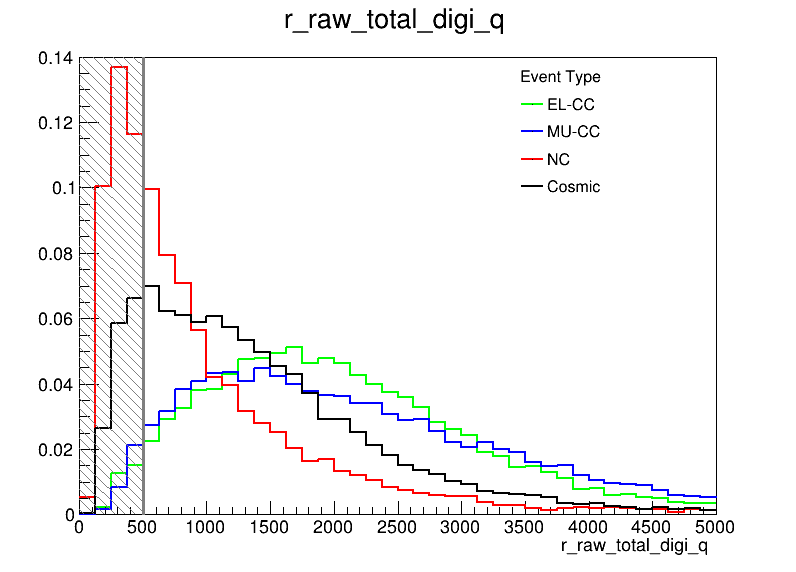

In [12]:
c.Draw()

In [13]:
# Plot the 'r_first_ring_height' which we cut on
y_max = 0.16
hists, leg = b_eval.combined_cat_plot('r_first_ring_height', 40, 0, 5000, 0, y_max, 'norm', False, False)
c = ROOT.TCanvas("r_first_ring_height", 'r_first_ring_height', 800, 600)
for hist in hists:
    hist.Draw("HISTSAME")

cut_line = ROOT.TLine(b_conf.eval.cuts.hough, 0, b_conf.eval.cuts.hough, y_max)
cut_line.SetLineWidth(3)
cut_line.SetLineColor(14)
cut_line.Draw()

cut_box = ROOT.TBox(0, 0, b_conf.eval.cuts.hough, y_max)
cut_box.SetFillColor(14)
cut_box.SetFillStyle(3345)
cut_box.Draw()

leg.Draw()

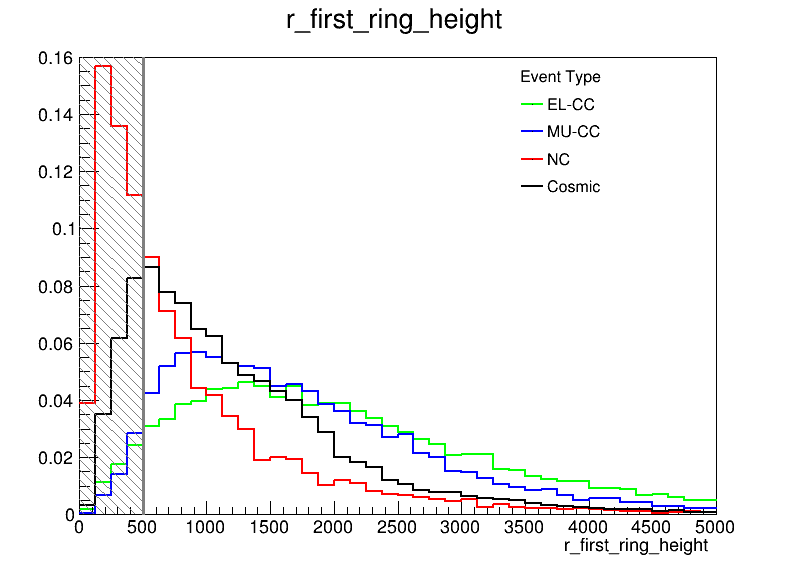

In [14]:
c.Draw()

In [15]:
# Plot the 'r_dirTheta' which we cut on
y_max = 0.25
hists, leg = b_eval.combined_cat_plot('r_dirTheta', 64, -1, 1, 0, y_max, 'norm', False, False)
c = ROOT.TCanvas("r_dirTheta", 'r_dirTheta', 800, 600)
for hist in hists:
    hist.Draw("HISTSAME")

cut_line_low = ROOT.TLine(-b_conf.eval.cuts.theta, 0, -b_conf.eval.cuts.theta, y_max)
cut_line_low.SetLineWidth(3)
cut_line_low.SetLineColor(14)
cut_line_low.Draw()
cut_box_low = ROOT.TBox(-1, 0, -b_conf.eval.cuts.theta, y_max)
cut_box_low.SetFillColor(14)
cut_box_low.SetFillStyle(3345)
cut_box_low.Draw()

cut_line_high = ROOT.TLine(b_conf.eval.cuts.theta, 0, b_conf.eval.cuts.theta, y_max)
cut_line_high.SetLineWidth(3)
cut_line_high.SetLineColor(14)
cut_line_high.Draw()
cut_box_high = ROOT.TBox(b_conf.eval.cuts.theta, 0, 1, y_max)
cut_box_high.SetFillColor(14)
cut_box_high.SetFillStyle(3345)
cut_box_high.Draw()

leg.Draw()

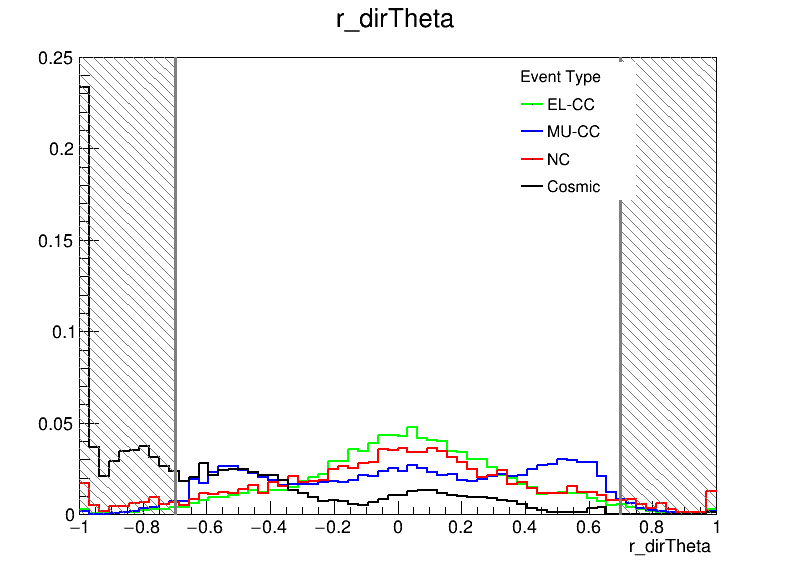

In [16]:
c.Draw()

In [17]:
# Plot the 'r_dirPhi' which we cut on
y_max = 0.17
hists, leg = b_eval.combined_cat_plot('r_dirPhi', 64, -1, 1, 0, y_max, 'norm', False, False)
c = ROOT.TCanvas("r_dirPhi", 'r_dirPhi', 800, 600)
for hist in hists:
    hist.Draw("HISTSAME")

cut_line_low = ROOT.TLine(-b_conf.eval.cuts.phi, 0, -b_conf.eval.cuts.phi, y_max)
cut_line_low.SetLineWidth(3)
cut_line_low.SetLineColor(14)
cut_line_low.Draw()
cut_box_low = ROOT.TBox(-1, 0, -b_conf.eval.cuts.phi, y_max)
cut_box_low.SetFillColor(14)
cut_box_low.SetFillStyle(3345)
cut_box_low.Draw()

cut_line_high = ROOT.TLine(b_conf.eval.cuts.phi, 0, b_conf.eval.cuts.phi, y_max)
cut_line_high.SetLineWidth(3)
cut_line_high.SetLineColor(14)
cut_line_high.Draw()
cut_box_high = ROOT.TBox(b_conf.eval.cuts.phi, 0, 1, y_max)
cut_box_high.SetFillColor(14)
cut_box_high.SetFillStyle(3345)
cut_box_high.Draw()

leg.Draw()

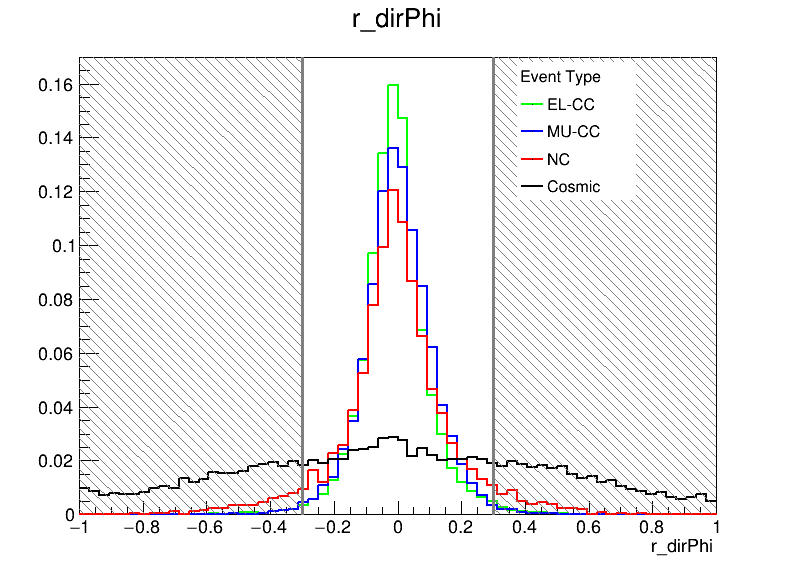

In [18]:
c.Draw()

In [19]:
# Print how these cuts affect the different categories
b_eval.base_cut_summary()

Base Cut Summary...

Nuel-CC-> Total 17831, Survived: 0.9102686332791207

Numu-CC-> Total 17540, Survived: 0.8970923603192702

NC-> Total 6740, Survived: 0.5100890207715133

Cosmic-> Total 21889, Survived: 0.20741011466946868



## Cosmic Classifier Evaluation

Next we will evaluate how well the cosmic classifier performs...

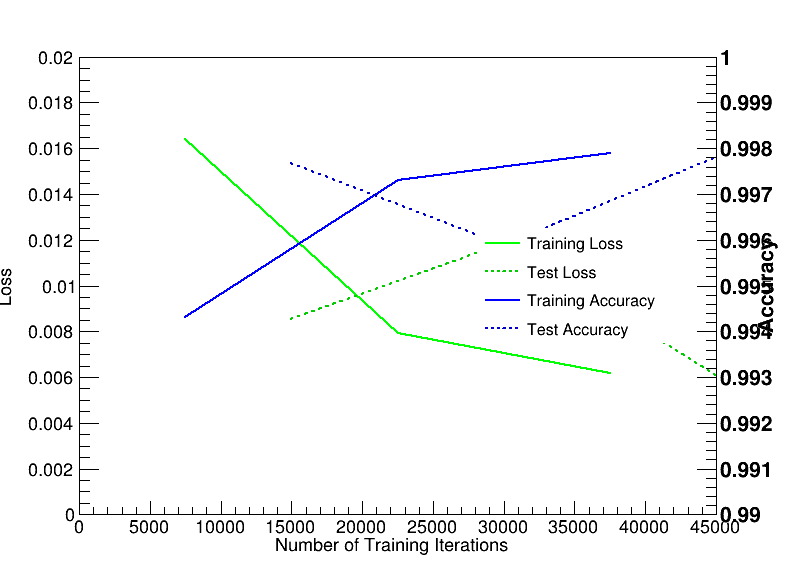

In [20]:
history_path = os.path.join(str(b_eval.config.models.cosmic.dir),
                            str(b_eval.config.models.cosmic.path),
                            'history.csv')
cosmic_history = pd.read_csv(history_path)

c_loss, c_accuracy, c_val_loss, c_val_accuracy = array('d'), array('d'), array('d'), array('d')
c_iterations, c_val_iterations = array('d'), array('d')
c_loss.fromlist(ast.literal_eval(cosmic_history["loss"].values[0]))
c_accuracy.fromlist(ast.literal_eval(cosmic_history["accuracy"].values[0]))
c_val_loss.fromlist(ast.literal_eval(cosmic_history["val_loss"].values[0]))
c_val_accuracy.fromlist(ast.literal_eval(cosmic_history["val_accuracy"].values[0]))
c_steps = b_conf.eval.steps_per_epoch
c_iterations.fromlist([i for i in range(int(c_steps/2), (len(c_loss)+1)*c_steps, c_steps)])
c_val_iterations.fromlist([i for i in range(c_steps, (len(c_loss)+1)*c_steps, c_steps)])

c_loss_g = ROOT.TGraph(len(c_loss), c_iterations, c_loss)
c_loss_g.SetName("c_loss_g")
c_accuracy_g = ROOT.TGraph(len(c_accuracy), c_iterations, c_accuracy)
c_accuracy_g.SetName("c_accuracy_g")
c_val_loss_g = ROOT.TGraph(len(c_val_loss), c_val_iterations, c_val_loss)
c_val_loss_g.SetName("c_val_loss_g")
c_val_accuracy_g = ROOT.TGraph(len(c_val_accuracy), c_val_iterations, c_val_accuracy)
c_val_accuracy_g.SetName("c_val_accuracy_g")

c = ROOT.TCanvas("c", "", 800, 600)
pad = ROOT.TPad("pad","", 0, 0, 1, 1)
pad.SetFillColor(0)
pad.Draw()
pad.cd()

# draw a frame to define the range
hr = pad.DrawFrame(0, 0, (len(c_loss))*c_steps, 0.02)
hr.SetXTitle("Number of Training Iterations")
hr.SetYTitle("Loss")
hr.GetYaxis().CenterTitle()
hr.GetXaxis().CenterTitle()
pad.GetFrame().SetFillColor(0)
pad.GetFrame().SetBorderSize(0)

# create first graph
c_loss_g.SetLineColor(ROOT.kGreen)     
c_loss_g.SetLineWidth(2)
c_loss_g.SetMarkerColor(ROOT.kGreen)
c_loss_g.SetMarkerStyle(1)
c_loss_g.Draw("LP")

c_val_loss_g.SetLineColor(ROOT.kGreen+1)     
c_val_loss_g.SetLineWidth(2)
c_val_loss_g.SetLineStyle(2)
c_val_loss_g.SetMarkerColor(ROOT.kGreen+1)
c_val_loss_g.SetMarkerStyle(1)
c_val_loss_g.Draw("LP")

# create second graph
# create a transparent pad drawn on top of the main pad
c.cd()
overlay = ROOT.TPad("overlay", "", 0, 0, 1, 1)
overlay.SetFillStyle(0)
overlay.SetFillColor(0)
overlay.SetFrameFillStyle(0)
overlay.Draw()
overlay.cd()

hframe = overlay.DrawFrame(pad.GetUxmin(), 0.99, pad.GetUxmax(), 1.0)
hframe.GetXaxis().SetLabelOffset(99)
hframe.GetYaxis().SetLabelOffset(100)
hframe.GetYaxis().SetTickLength(0) 

c_accuracy_g.SetLineColor(ROOT.kBlue)     
c_accuracy_g.SetLineWidth(2)
c_accuracy_g.SetMarkerColor(ROOT.kBlue)
c_accuracy_g.SetMarkerStyle(1)
c_accuracy_g.Draw("LP")

c_val_accuracy_g.SetLineColor(ROOT.kBlue+1)     
c_val_accuracy_g.SetLineWidth(2)
c_val_accuracy_g.SetLineStyle(2)
c_val_accuracy_g.SetMarkerColor(ROOT.kBlue+1)
c_val_accuracy_g.SetMarkerStyle(1)
c_val_accuracy_g.Draw("LP")

# Draw an axis on the right side
axis = ROOT.TGaxis(pad.GetUxmax(), 0.99, pad.GetUxmax(), 1.0, 
                   0.99, 1.0, 510, "+L")
axis.SetTitleSize(.04)
axis.SetTitle("Accuracy")
axis.CenterTitle()
axis.Draw()

leg = ROOT.TLegend(0.60, 0.40, 0.85, 0.6)
leg.AddEntry(c_loss_g, "Training Loss", "LP")
leg.AddEntry(c_val_loss_g, "Test Loss", "LP")
leg.AddEntry(c_accuracy_g, "Training Accuracy", "LP")
leg.AddEntry(c_val_accuracy_g, "Test Accuracy", "LP")
leg.SetTextSize(0.03)
leg.SetTextFont(42)
leg.SetFillColor(0)
leg.SetFillStyle(1001)
leg.SetBorderSize(0)
leg.Draw()

c.Draw()

In [21]:
# Plot the cosmic output which we cut on
hists, leg = b_eval.combined_cat_plot('c_out', 50, 0, 1.0001, 0, 1, 'norm', True, False)
c = ROOT.TCanvas("c_out", 'c_out', 800, 600)
for hist in hists:
    hist.Draw("HISTSAME")
#leg.Draw()

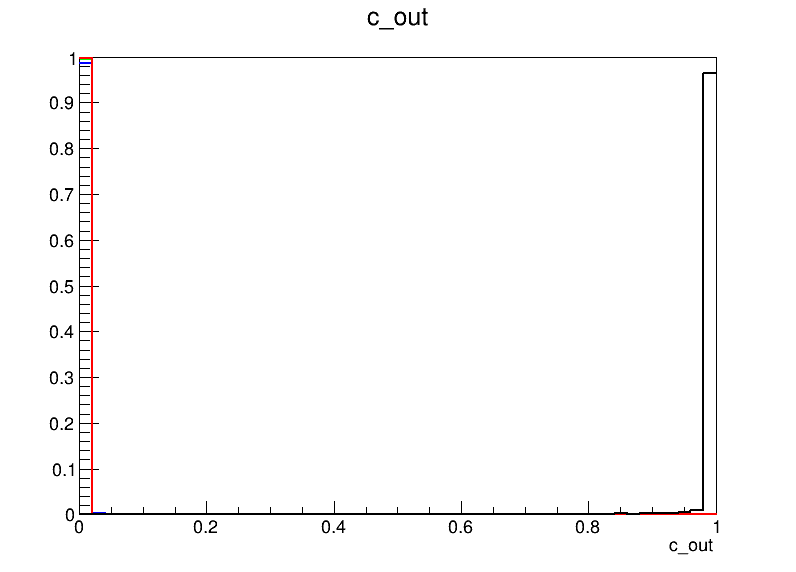

In [22]:
c.Draw()

In [23]:
# Print how this cut affects the different categories
print("Applying cut at cosmic output value: {}\n".format(b_conf.eval.cuts.cosmic))
b_eval.combined_cut_summary()

Applying cut at cosmic output value: 0.001

Base + Cosmic Cut Summary...

Nuel-CC-> Total 17831, Survived: 0.9000616903146206

Numu-CC-> Total 17540, Survived: 0.8750285062713797

NC-> Total 6740, Survived: 0.5060830860534125

Cosmic-> Total 21889, Survived: 0.0



In [24]:
# Plot the true nuEnergy with base_cut and cosmic_cut for the beam sample
hists, leg = b_eval.combined_cat_plot('t_nuEnergy', 50, 0, 10000, 0, 0.09, 'norm', True, True)
c = ROOT.TCanvas("t_nuEnergy", 't_nuEnergy', 800, 600)
for hist in hists:
    hist.Draw("HISTSAME")
leg.Draw()

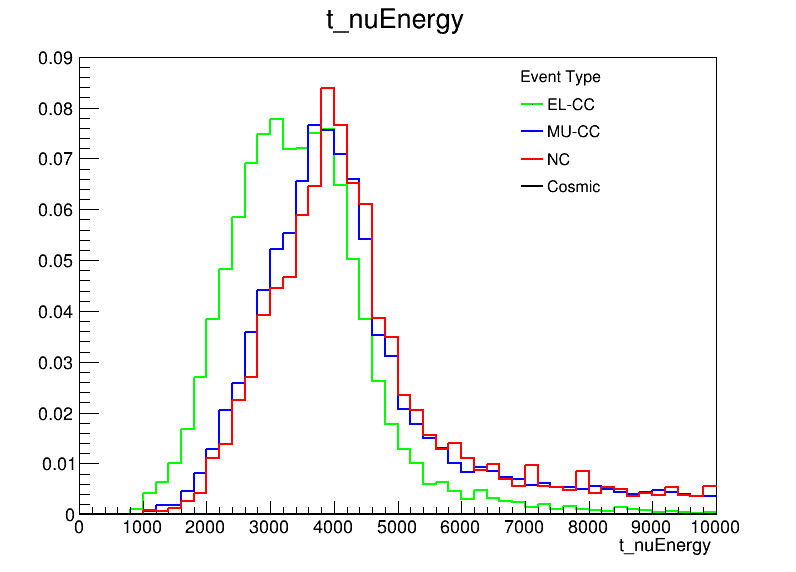

In [25]:
# Beam sample neutrino energy distribution of events that pass base+cosmic cuts
c.Draw()

In [26]:
# Plot the true nuEnergy with base_cut and cosmic_cut for the uniform sample
hists, leg = u_eval.combined_cat_plot('t_nuEnergy', 50, 0, 10000, 0, 0.09, 'norm', True, True)
c = ROOT.TCanvas("t_nuEnergy", 't_nuEnergy', 800, 600)
for hist in hists:
    hist.Draw("HISTSAME")
leg.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: h_t_nuEnergy_EL-CC (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_t_nuEnergy_MU-CC (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_t_nuEnergy_NC (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_t_nuEnergy_Cosmic (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: t_nuEnergy


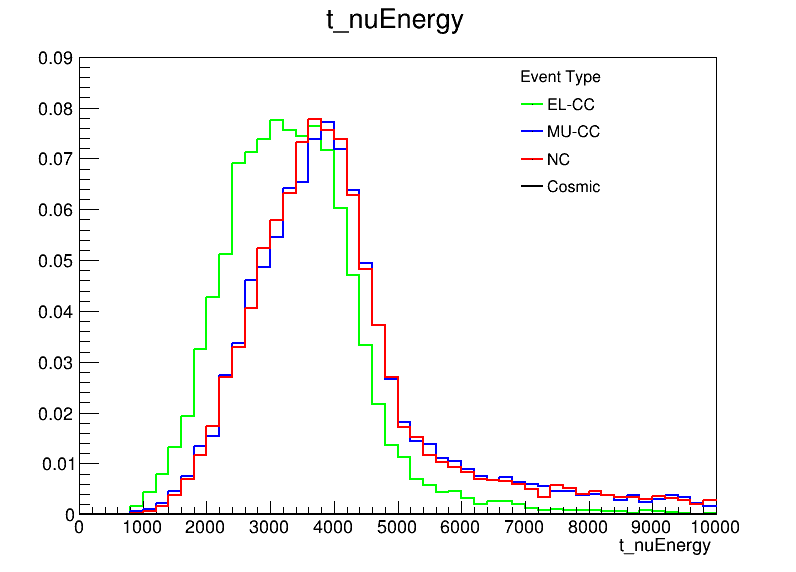

In [27]:
# Uniform sample neutrino energy distribution of events that pass base+cosmic cuts
c.Draw()

In [28]:
N = 7500
cosmic_data = []
cosmic_data.append(u_eval.events[u_eval.events.t_cosmic_cat == True][:N])
cosmic_data.append(u_eval.events[u_eval.events.t_cosmic_cat == False][:N])
cosmic_data = pd.concat(cosmic_data)
cosmic_data = cosmic_data[['t_cat', 't_full_cat', 't_cosmic_cat', 't_nu_nc_cat', 't_nc_cat', 'c_dense']]
cosmic_data = cosmic_data.sample(frac=1).reset_index(drop=True)

# Remove dense output mean and scale to unit variance
cosmic_scaler = StandardScaler()  
cosmic_dense = np.stack(cosmic_data['c_dense'])
cosmic_dense = cosmic_scaler.fit_transform(cosmic_dense)  

In [29]:
cosmic_pca = PCA(n_components=3)
cosmic_pca_result = cosmic_pca.fit_transform(cosmic_dense)
cosmic_pca_df = pd.DataFrame(cosmic_pca_result)
cosmic_data['cosmic-pca-0'] = cosmic_pca_df[0]
cosmic_data['cosmic-pca-1'] = cosmic_pca_df[1]
cosmic_data['cosmic-pca-2'] = cosmic_pca_df[2]
print('Explained variation per principal component: {}'.format(cosmic_pca.explained_variance_ratio_))

Explained variation per principal component: [0.37895778 0.18022121 0.11100724]


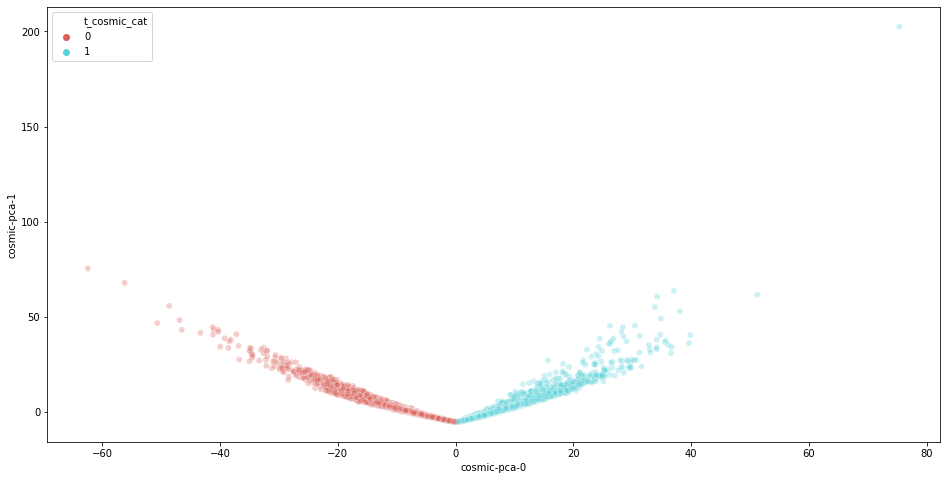

In [30]:
plt.figure(figsize=(16,8))
sns.scatterplot(x="cosmic-pca-0", y="cosmic-pca-1", hue="t_cosmic_cat", palette=sns.color_palette("hls", 2), data=cosmic_data, legend="full", alpha=0.3)
plt.show()

In [31]:
cosmic_tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
cosmic_tsne_results = cosmic_tsne.fit_transform(cosmic_dense)
cosmic_tsne_df = pd.DataFrame(cosmic_tsne_results)
cosmic_data['cosmic-tsne-0'] = cosmic_tsne_df[0]
cosmic_data['cosmic-tsne-1'] = cosmic_tsne_df[1]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 15000 samples in 2.186s...
[t-SNE] Computed neighbors for 15000 samples in 267.797s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed conditional probabilities for 

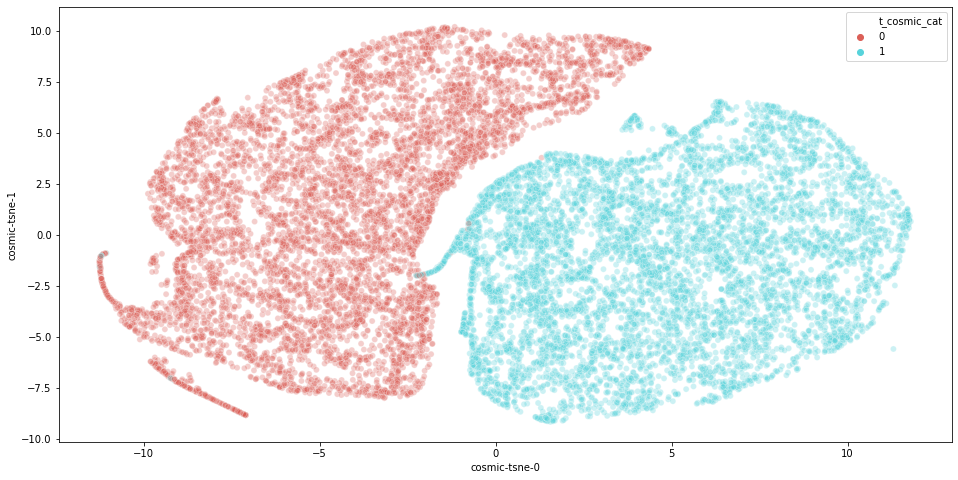

In [32]:
plt.figure(figsize=(16,8))
sns.scatterplot(x="cosmic-tsne-0", y="cosmic-tsne-1", hue="t_cosmic_cat", palette=sns.color_palette("hls", 2), data=cosmic_data, legend="full", alpha=0.3)
plt.show()

## Beam Classifier Evaluation

Next we will evaluate how well the beam classifier performed...

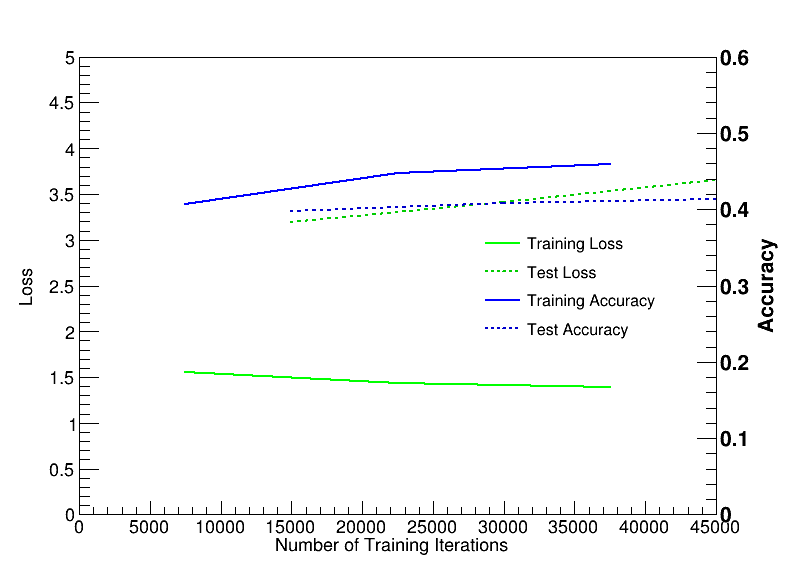

In [33]:
beam_history = pd.read_csv(b_eval.b_model.config.exp.exp_dir + '/history.csv')

b_loss, b_accuracy, b_val_loss, b_val_accuracy = array('d'), array('d'), array('d'), array('d')
b_iterations, b_val_iterations = array('d'), array('d')
b_loss.fromlist(ast.literal_eval(beam_history["loss"].values[0]))
b_accuracy.fromlist(ast.literal_eval(beam_history["accuracy"].values[0]))
b_val_loss.fromlist(ast.literal_eval(beam_history["val_loss"].values[0]))
b_val_accuracy.fromlist(ast.literal_eval(beam_history["val_accuracy"].values[0]))
b_steps = b_conf.eval.steps_per_epoch
b_iterations.fromlist([i for i in range(int(b_steps/2), (len(b_loss)+1)*b_steps, b_steps)])
b_val_iterations.fromlist([i for i in range(b_steps, (len(b_loss)+1)*b_steps, b_steps)])

b_loss_g = ROOT.TGraph(len(b_loss), b_iterations, b_loss)
b_loss_g.SetName("b_loss_g")
b_accuracy_g = ROOT.TGraph(len(b_accuracy), b_iterations, b_accuracy)
b_accuracy_g.SetName("b_accuracy_g")
b_val_loss_g = ROOT.TGraph(len(b_val_loss), b_val_iterations, b_val_loss)
b_val_loss_g.SetName("b_val_loss_g")
b_val_accuracy_g = ROOT.TGraph(len(b_val_accuracy), b_val_iterations, b_val_accuracy)
b_val_accuracy_g.SetName("b_val_accuracy_g")

c = ROOT.TCanvas("c", "", 800, 600)
pad = ROOT.TPad("pad","", 0, 0, 1, 1)
pad.SetFillColor(0)
pad.Draw()
pad.cd()

# draw a frame to define the range
hr = pad.DrawFrame(0, 0, (len(b_loss))*b_steps, 5)
hr.SetXTitle("Number of Training Iterations")
hr.SetYTitle("Loss")
hr.GetYaxis().CenterTitle()
hr.GetXaxis().CenterTitle()
pad.GetFrame().SetFillColor(0)
pad.GetFrame().SetBorderSize(0)

# create first graph
b_loss_g.SetLineColor(ROOT.kGreen)     
b_loss_g.SetLineWidth(2)
b_loss_g.SetMarkerColor(ROOT.kGreen)
b_loss_g.SetMarkerStyle(1)
b_loss_g.Draw("LP")

b_val_loss_g.SetLineColor(ROOT.kGreen+1)     
b_val_loss_g.SetLineWidth(2)
b_val_loss_g.SetLineStyle(2)
b_val_loss_g.SetMarkerColor(ROOT.kGreen+1)
b_val_loss_g.SetMarkerStyle(1)
b_val_loss_g.Draw("LP")

# create second graph
# create a transparent pad drawn on top of the main pad
c.cd()
overlay = ROOT.TPad("overlay", "", 0, 0, 1, 1)
overlay.SetFillStyle(0)
overlay.SetFillColor(0)
overlay.SetFrameFillStyle(0)
overlay.Draw()
overlay.cd()

hframe = overlay.DrawFrame(pad.GetUxmin(), 0, pad.GetUxmax(), 0.6)
hframe.GetXaxis().SetLabelOffset(99)
hframe.GetYaxis().SetLabelOffset(100)
hframe.GetYaxis().SetTickLength(0) 

b_accuracy_g.SetLineColor(ROOT.kBlue)     
b_accuracy_g.SetLineWidth(2)
b_accuracy_g.SetMarkerColor(ROOT.kBlue)
b_accuracy_g.SetMarkerStyle(1)
b_accuracy_g.Draw("LP")

b_val_accuracy_g.SetLineColor(ROOT.kBlue+1)     
b_val_accuracy_g.SetLineWidth(2)
b_val_accuracy_g.SetLineStyle(2)
b_val_accuracy_g.SetMarkerColor(ROOT.kBlue+1)
b_val_accuracy_g.SetMarkerStyle(1)
b_val_accuracy_g.Draw("LP")

# Draw an axis on the right side
axis = ROOT.TGaxis(pad.GetUxmax(), 0, pad.GetUxmax(), 0.6, 
                   0, 0.6, 510, "+L")
axis.SetTitleSize(.04)
axis.SetTitle("Accuracy")
axis.CenterTitle()
axis.Draw()

leg = ROOT.TLegend(0.60, 0.40, 0.85, 0.6)
leg.AddEntry(b_loss_g, "Training Loss", "LP")
leg.AddEntry(b_val_loss_g, "Test Loss", "LP")
leg.AddEntry(b_accuracy_g, "Training Accuracy", "LP")
leg.AddEntry(b_val_accuracy_g, "Test Accuracy", "LP")
leg.SetTextSize(0.03)
leg.SetTextFont(42)
leg.SetFillColor(0)
leg.SetFillStyle(1001)
leg.SetBorderSize(0)
leg.Draw()

c.Draw()

In [34]:
# Plot the 'nuel_score' with the cuts applied and normalised per event type for the beam sample
nuel_hists, leg = b_eval.combined_cat_plot('nuel_score', 50, 0, 1, 0, 0.12, 'norm', True, True)
c = ROOT.TCanvas("nuel_score", 'nuel_score', 800, 600)
for hist in nuel_hists:
    hist.Draw("HISTSAME")
#leg.Draw()

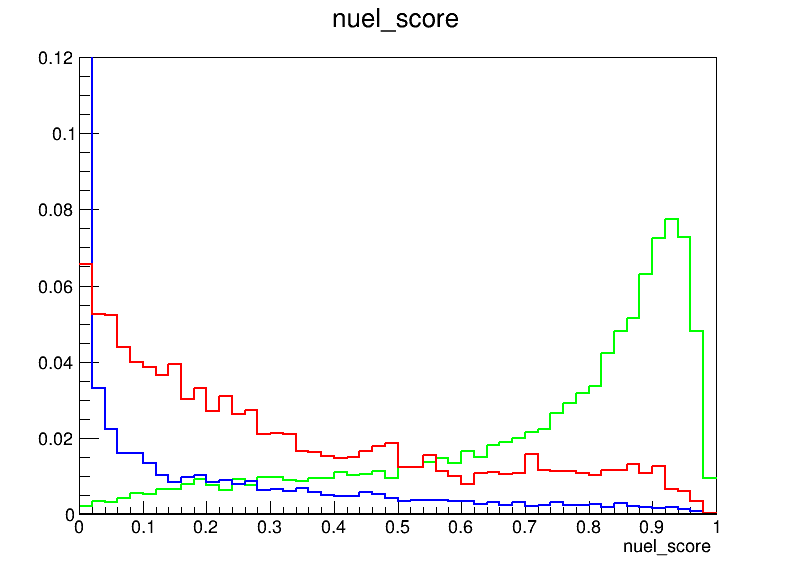

In [35]:
c.Draw() # Beam sample nuel score

In [36]:
# Plot the 'nuel_score' with the cuts applied and normalised per event type for the uniform sample
nuel_hists, leg = u_eval.combined_cat_plot('nuel_score', 50, 0, 1, 0, 0.12, 'norm', True, True)
c = ROOT.TCanvas("nuel_score", 'nuel_score', 800, 600)
for hist in nuel_hists:
    hist.Draw("HISTSAME")
#leg.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: h_nuel_score_EL-CC (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_nuel_score_MU-CC (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_nuel_score_NC (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_nuel_score_Cosmic (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: nuel_score


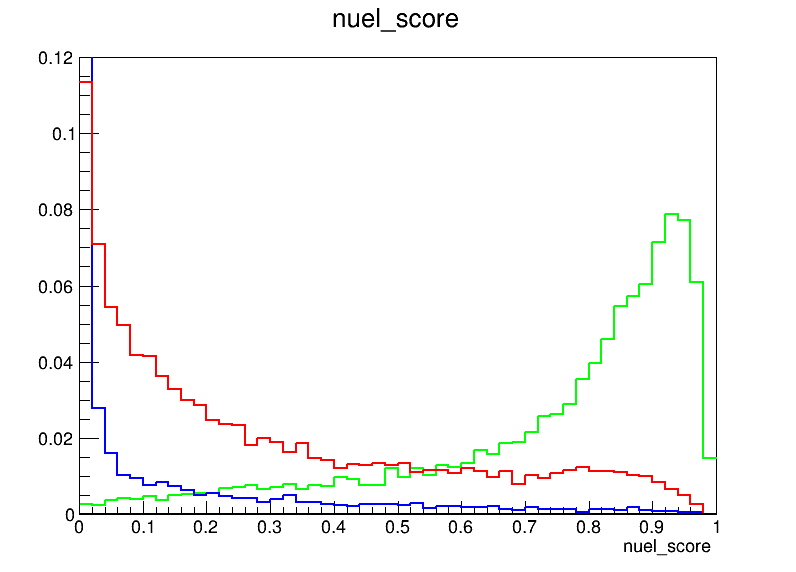

In [37]:
c.Draw() # Uniform sample nuel score

In [38]:
# Plot the 'numu_score' with the cuts applied and normalised per event type for the beam sample
numu_hists, leg = b_eval.combined_cat_plot('numu_score', 50, 0, 1, 0, 0.8, 'norm', True, True)
c = ROOT.TCanvas("numu_score", 'numu_score', 800, 600)
for hist in numu_hists:
    hist.Draw("HISTSAME")
#leg.Draw()

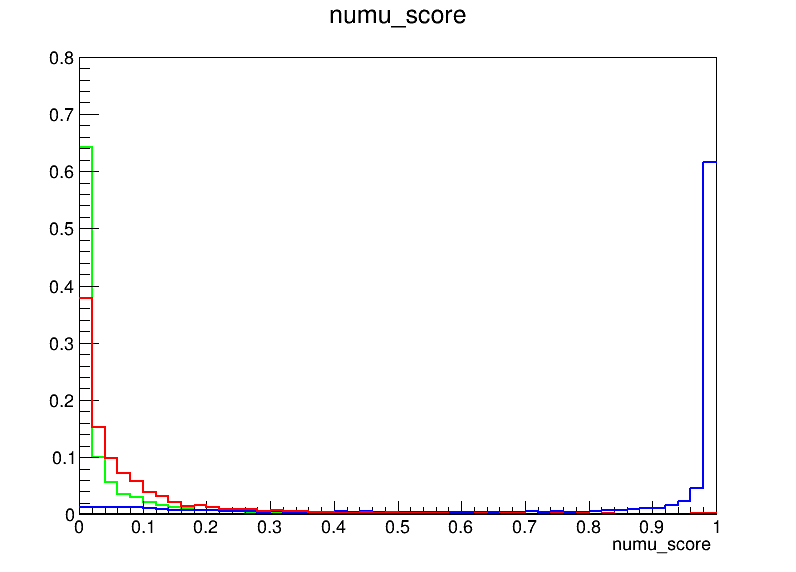

In [39]:
c.Draw() # Beam sample numu score

In [40]:
# Plot the 'numu_score' with the cuts applied and normalised per event type for the uniform sample
numu_hists, leg = u_eval.combined_cat_plot('numu_score', 50, 0, 1, 0, 0.8, 'norm', True, True)
c = ROOT.TCanvas("numu_score", 'numu_score', 800, 600)
for hist in numu_hists:
    hist.Draw("HISTSAME")
#leg.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: h_numu_score_EL-CC (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_numu_score_MU-CC (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_numu_score_NC (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_numu_score_Cosmic (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: numu_score


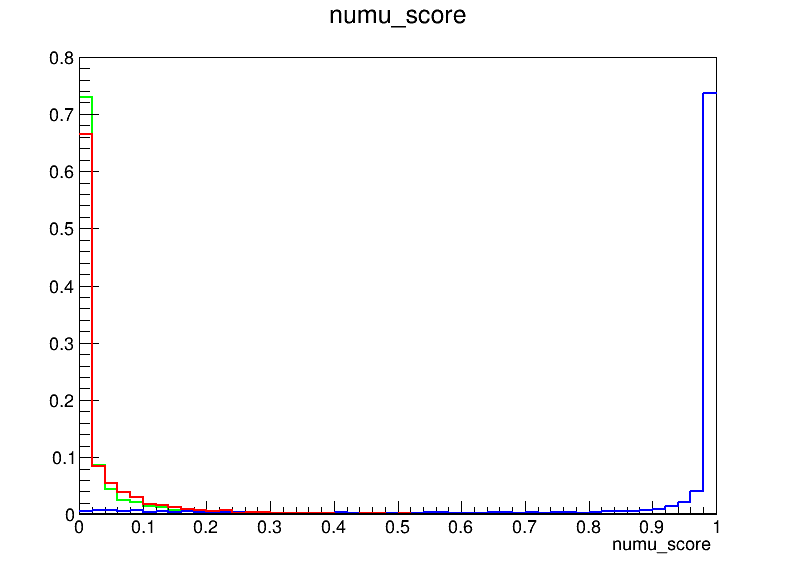

In [41]:
c.Draw() # Uniform sample numu score

In [42]:
# Plot the 'nc_score' with the cuts applied and normalised per event type for the beam sample
nc_hists, leg = b_eval.combined_cat_plot('nc_score', 50, 0, 1, 0, 0.1, 'norm', True, True)
c = ROOT.TCanvas("nc_score", 'nc_score', 800, 600)
for hist in nc_hists:
    hist.Draw("HISTSAME")
#leg.Draw()

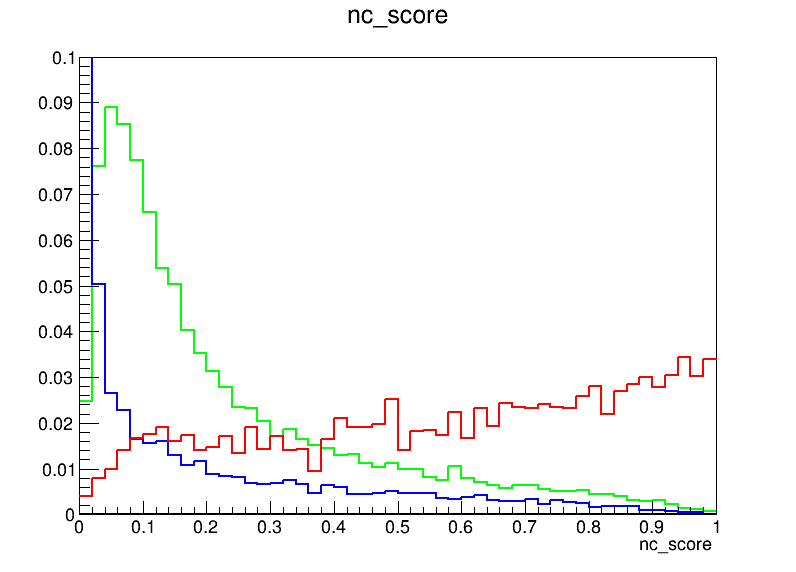

In [43]:
c.Draw() # Beam sample nc score

In [44]:
# Plot the 'nc_score' with the cuts applied and normalised per event type for the uniform sample
nc_hists, leg = u_eval.combined_cat_plot('nc_score', 50, 0, 1, 0, 0.1, 'norm', True, True)
c = ROOT.TCanvas("nc_score", 'nc_score', 800, 600)
for hist in nc_hists:
    hist.Draw("HISTSAME")
#leg.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: h_nc_score_EL-CC (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_nc_score_MU-CC (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_nc_score_NC (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_nc_score_Cosmic (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: nc_score


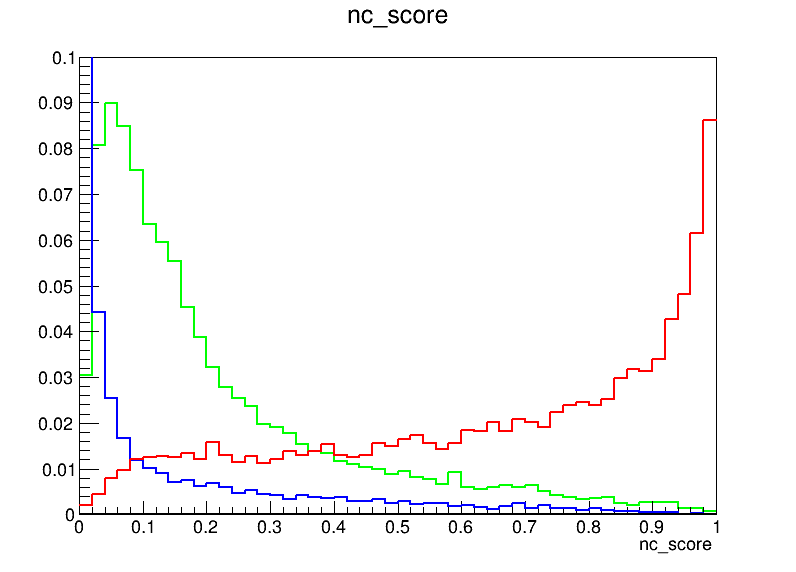

In [45]:
c.Draw() # Uniform sample nc score

In [46]:
# Run a scan on nuel_score and numu_score cuts to find maximum efficiency*purity for both
b_ev = b_eval.events[(b_eval.events.base_cut == 0) & (b_eval.events.cosmic_cut == 0)]

nuel_tot = b_ev[b_ev.t_full_cat == 0]['weight'].sum()
numu_tot = b_ev[b_ev.t_full_cat == 1]['weight'].sum()
nc_tot = b_ev[b_ev.t_full_cat == 2]['weight'].sum()
 
cut = array('d')
nuel_eff_sig, nuel_eff_bkg, nuel_pur, nuel_fom = array('d'), array('d'), array('d'), array('d')
numu_eff_sig, numu_eff_bkg, numu_pur, numu_fom = array('d'), array('d'), array('d'), array('d')
nc_eff_sig, nc_eff_bkg, nc_pur, nc_fom = array('d'), array('d'), array('d'), array('d')

bins = 100
nuel_max_fom = 0.0
numu_max_fom = 0.0
nc_max_fom = 0.0
nuel_max_fom_cut = 0
numu_max_fom_cut = 0
nc_max_fom_cut = 0

cut.append(0.0)
nuel_eff_sig.append(1.0)
numu_eff_sig.append(1.0)
nc_eff_sig.append(1.0)
nuel_eff_bkg.append(1.0)
numu_eff_bkg.append(1.0)
nc_eff_bkg.append(1.0)
nuel_pur.append(nuel_tot/(nuel_tot+numu_tot+nc_tot))
numu_pur.append(numu_tot/(nuel_tot+numu_tot+nc_tot))
nc_pur.append(nc_tot/(nuel_tot+numu_tot+nc_tot))
nuel_fom.append(nuel_eff_sig[0]*nuel_pur[0])
numu_fom.append(numu_eff_sig[0]*numu_pur[0])
nc_fom.append(nc_eff_sig[0]*nc_pur[0])

for bin in range(bins):
    cut.append((bin * 0.01) + 0.01)
    
    nuel_nuel_cut = b_ev[(b_ev.t_full_cat == 0) & (b_ev.nuel_score > cut[bin+1])]['weight'].sum()
    numu_nuel_cut = b_ev[(b_ev.t_full_cat == 1) & (b_ev.nuel_score > cut[bin+1])]['weight'].sum()
    nc_nuel_cut = b_ev[(b_ev.t_full_cat == 2) & (b_ev.nuel_score > cut[bin+1])]['weight'].sum()
    
    nuel_numu_cut = b_ev[(b_ev.t_full_cat == 0) & (b_ev.numu_score > cut[bin+1])]['weight'].sum()
    numu_numu_cut = b_ev[(b_ev.t_full_cat == 1) & (b_ev.numu_score > cut[bin+1])]['weight'].sum()
    nc_numu_cut = b_ev[(b_ev.t_full_cat == 2) & (b_ev.numu_score > cut[bin+1])]['weight'].sum()
    
    nuel_nc_cut = b_ev[(b_ev.t_full_cat == 0) & (b_ev.nc_score > cut[bin+1])]['weight'].sum()
    numu_nc_cut = b_ev[(b_ev.t_full_cat == 1) & (b_ev.nc_score > cut[bin+1])]['weight'].sum()
    nc_nc_cut = b_ev[(b_ev.t_full_cat == 2) & (b_ev.nc_score > cut[bin+1])]['weight'].sum()
    
    nuel_eff_sig.append(nuel_nuel_cut/nuel_tot)
    numu_eff_sig.append(numu_numu_cut/numu_tot)
    nc_eff_sig.append(nc_nc_cut/nc_tot)
    
    nuel_eff_bkg.append((numu_nuel_cut+nc_nuel_cut)/(numu_tot+nc_tot))
    numu_eff_bkg.append((nuel_numu_cut+nc_numu_cut)/(nuel_tot+nc_tot))
    nc_eff_bkg.append((nuel_nc_cut+numu_nc_cut)/(nuel_tot+numu_tot))
    
    if nuel_eff_sig[bin+1] == 0.0 or nuel_eff_bkg[bin+1] == 0.0:
        nuel_pur.append(0.0)
        nuel_fom.append(0.0)
    else:
        nuel_pur.append(nuel_nuel_cut/(nuel_nuel_cut+numu_nuel_cut+nc_nuel_cut))
        nuel_fom.append(nuel_eff_sig[bin]*nuel_pur[bin])
        
    if numu_eff_sig[bin+1] == 0.0 or numu_eff_bkg[bin+1] == 0.0:
        numu_pur.append(0.0)
        numu_fom.append(0.0)
    else:
        numu_pur.append(numu_numu_cut/(nuel_numu_cut+numu_numu_cut+nc_numu_cut))
        numu_fom.append(numu_eff_sig[bin]*numu_pur[bin])
        
    if nc_eff_sig[bin+1] == 0.0 or nc_eff_bkg[bin+1] == 0.0:
        nc_pur.append(0.0)
        nc_fom.append(0.0)
    else:
        nc_pur.append(nc_nc_cut/(nuel_nc_cut+numu_nc_cut+nc_nc_cut))
        nc_fom.append(nc_eff_sig[bin]*nc_pur[bin])
        
    #print("Cut: {0:.4f}, Sig Eff:{1:.4f}, Bkg Eff: {2:.4f}, Pur: {3:.4f}, Fom: {4:.4f}".format(
    #    cut[bin+1], nuel_eff_sig[bin+1], nuel_eff_bkg[bin+1], nuel_pur[bin+1], nuel_fom[bin+1]))
    #print("Cut: {0:.4f}, Sig Eff:{1:.4f}, Bkg Eff: {2:.4f}, Pur: {3:.4f}, Fom: {4:.4f}".format(
    #    cut[bin+1], numu_eff_sig[bin+1], numu_eff_bkg[bin+1], numu_pur[bin+1], numu_fom[bin+1]))
    #print("Cut: {0:.4f}, Sig Eff:{1:.4f}, Bkg Eff: {2:.4f}, Pur: {3:.4f}, Fom: {4:.4f}".format(
    #    cut[bin+1], nc_eff_sig[bin+1], nc_eff_bkg[bin+1], nc_pur[bin+1], nc_fom[bin+1]))

    if nuel_fom[bin] > nuel_max_fom: 
        nuel_max_fom = nuel_fom[bin] 
        nuel_max_fom_cut = cut[bin]
        
    if numu_fom[bin] > numu_max_fom: 
        numu_max_fom = numu_fom[bin] 
        numu_max_fom_cut = cut[bin]
        
    if nc_fom[bin] > nc_max_fom: 
        nc_max_fom = nc_fom[bin] 
        nc_max_fom_cut = cut[bin]

In [47]:
nuel_eff_sig_g = ROOT.TGraph(bins+1, cut, nuel_eff_sig)
nuel_eff_sig_g.SetName("nuel_eff_sig_g")
nuel_eff_bkg_g = ROOT.TGraph(bins+1, cut, nuel_eff_bkg)
nuel_eff_bkg_g.SetName("nuel_eff_bkg_g")
nuel_pur_g = ROOT.TGraph(bins+1, cut, nuel_pur)
nuel_pur_g.SetName("nuel_pur_g")
nuel_fom_g = ROOT.TGraph(bins+1, cut, nuel_fom)
nuel_fom_g.SetName("nuel_fom_g")
nuel_eff_vs_bkg_g = ROOT.TGraph(bins+1, nuel_eff_bkg, nuel_eff_sig)
nuel_eff_vs_bkg_g.SetName("nuel_eff_vs_bkg_g")

c = ROOT.TCanvas("c", "", 800, 600)
c.cd()

nuel_eff_sig_g.SetLineColor(ROOT.kGreen)     
nuel_eff_sig_g.SetLineWidth(2)
nuel_eff_sig_g.SetMarkerColor(ROOT.kGreen)
nuel_eff_sig_g.SetTitle("Scan across nuel_score cut")
nuel_eff_sig_g.GetXaxis().SetTitle('nuel_score cut')
nuel_eff_sig_g.GetXaxis().SetRangeUser(0, 1)
nuel_eff_sig_g.GetYaxis().SetRangeUser(0, 1)
nuel_eff_sig_g.Draw("sameALP")

nuel_eff_bkg_g.SetLineColor(ROOT.kBlue)     
nuel_eff_bkg_g.SetLineWidth(2)
nuel_eff_bkg_g.SetMarkerColor(ROOT.kBlue)
nuel_eff_bkg_g.Draw("sameLP")

nuel_pur_g.SetLineColor(ROOT.kRed)     
nuel_pur_g.SetLineWidth(2)
nuel_pur_g.SetMarkerColor(ROOT.kRed)
nuel_pur_g.Draw("sameLP")

nuel_fom_g.SetLineColor(ROOT.kBlack)     
nuel_fom_g.SetLineWidth(2)
nuel_fom_g.SetMarkerColor(ROOT.kBlack)
nuel_fom_g.Draw("sameLP")

nuel_eff_vs_bkg_g.SetLineColor(ROOT.kYellow)     
nuel_eff_vs_bkg_g.SetLineWidth(2)
nuel_eff_vs_bkg_g.SetMarkerColor(ROOT.kYellow)
nuel_eff_vs_bkg_g.Draw("sameLP")

leg = ROOT.TLegend(0.65, 0.65, 0.85, 0.85)
leg.AddEntry(nuel_eff_sig_g, "Sig Eff", "LP")
leg.AddEntry(nuel_eff_bkg_g, "Bkg Eff", "LP")
leg.AddEntry(nuel_pur_g, "Purity", "LP")
leg.AddEntry(nuel_fom_g, "FOM", "LP")
leg.AddEntry(nuel_eff_vs_bkg_g, "SigVsBkg", "LP")
leg.SetTextSize(0.03)
leg.SetTextFont(42)
leg.SetFillColor(0)
leg.SetFillStyle(1001)
leg.Draw()

c.SetGridx()
c.SetGridy()
c.Update()

Max Figure-of-merit: 0.15832650872160536, at cut value: 0.77


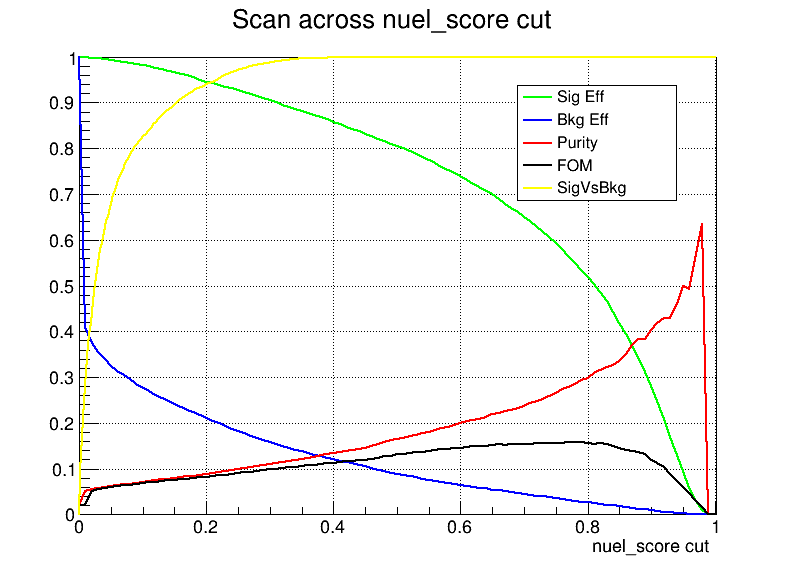

In [48]:
c.Draw()
print("Max Figure-of-merit: {}, at cut value: {}".format(nuel_max_fom, nuel_max_fom_cut))

In [49]:
numu_eff_sig_g = ROOT.TGraph(bins+1, cut, numu_eff_sig)
numu_eff_sig_g.SetName("numu_eff_sig_g")
numu_eff_bkg_g = ROOT.TGraph(bins+1, cut, numu_eff_bkg)
numu_eff_bkg_g.SetName("numu_eff_bkg_g")
numu_pur_g = ROOT.TGraph(bins+1, cut, numu_pur)
numu_pur_g.SetName("numu_pur_g")
numu_fom_g = ROOT.TGraph(bins+1, cut, numu_fom)
numu_fom_g.SetName("numu_fom_g")
numu_eff_vs_bkg_g = ROOT.TGraph(bins+1, numu_eff_bkg, numu_eff_sig)
numu_eff_vs_bkg_g.SetName("numu_eff_vs_bkg_g")

c = ROOT.TCanvas("c", "", 800, 600)
c.cd()

numu_eff_sig_g.SetLineColor(ROOT.kGreen)     
numu_eff_sig_g.SetLineWidth(2)
numu_eff_sig_g.SetMarkerColor(ROOT.kGreen)
numu_eff_sig_g.SetTitle("Scan across numu_score cut")
numu_eff_sig_g.GetXaxis().SetTitle('numu_score cut')
numu_eff_sig_g.GetXaxis().SetRangeUser(0, 1)
numu_eff_sig_g.GetYaxis().SetRangeUser(0, 1)
numu_eff_sig_g.Draw("sameALP")

numu_eff_bkg_g.SetLineColor(ROOT.kBlue)     
numu_eff_bkg_g.SetLineWidth(2)
numu_eff_bkg_g.SetMarkerColor(ROOT.kBlue)
numu_eff_bkg_g.Draw("sameLP")

numu_pur_g.SetLineColor(ROOT.kRed)     
numu_pur_g.SetLineWidth(2)
numu_pur_g.SetMarkerColor(ROOT.kRed)
numu_pur_g.Draw("sameLP")

numu_fom_g.SetLineColor(ROOT.kBlack)     
numu_fom_g.SetLineWidth(2)
numu_fom_g.SetMarkerColor(ROOT.kBlack)
numu_fom_g.Draw("sameLP")

numu_eff_vs_bkg_g.SetLineColor(ROOT.kYellow)     
numu_eff_vs_bkg_g.SetLineWidth(2)
numu_eff_vs_bkg_g.SetMarkerColor(ROOT.kYellow)
numu_eff_vs_bkg_g.Draw("sameLP")

leg = ROOT.TLegend(0.65, 0.65, 0.85, 0.85)
leg.AddEntry(numu_eff_sig_g, "Sig Eff", "LP")
leg.AddEntry(numu_eff_bkg_g, "Bkg Eff", "LP")
leg.AddEntry(numu_pur_g, "Purity", "LP")
leg.AddEntry(numu_fom_g, "FOM", "LP")
leg.AddEntry(numu_eff_vs_bkg_g, "SigVsBkg", "LP")
leg.SetTextSize(0.03)
leg.SetTextFont(42)
leg.SetFillColor(42)
leg.SetFillStyle(1001)
leg.Draw()

c.SetGridx()
c.SetGridy()
c.Update()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


Max Figure-of-merit: 0.9072158131884428, at cut value: 0.05


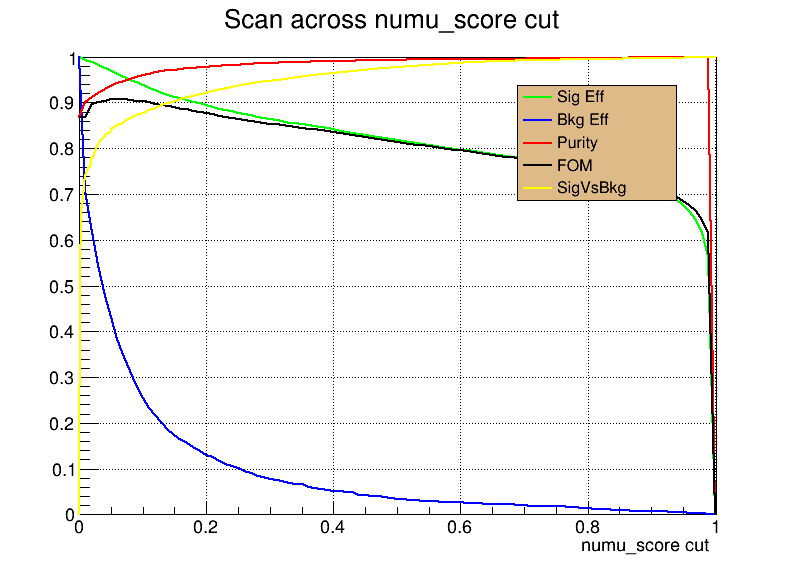

In [50]:
c.Draw()
print("Max Figure-of-merit: {}, at cut value: {}".format(numu_max_fom, numu_max_fom_cut))

In [51]:
nc_eff_sig_g = ROOT.TGraph(bins+1, cut, nc_eff_sig)
nc_eff_sig_g.SetName("nc_eff_sig_g")
nc_eff_bkg_g = ROOT.TGraph(bins+1, cut, nc_eff_bkg)
nc_eff_bkg_g.SetName("nc_eff_bkg_g")
nc_pur_g = ROOT.TGraph(bins+1, cut, nc_pur)
nc_pur_g.SetName("nc_pur_g")
nc_fom_g = ROOT.TGraph(bins+1, cut, nc_fom)
nc_fom_g.SetName("nc_fom_g")
nc_eff_vs_bkg_g = ROOT.TGraph(bins+1, nc_eff_bkg, nc_eff_sig)
nc_eff_vs_bkg_g.SetName("nc_eff_vs_bkg_g")

c = ROOT.TCanvas("c", "", 800, 600)
c.cd()

nc_eff_sig_g.SetLineColor(ROOT.kGreen)     
nc_eff_sig_g.SetLineWidth(2)
nc_eff_sig_g.SetMarkerColor(ROOT.kGreen)
nc_eff_sig_g.SetTitle("Scan across nc_score cut")
nc_eff_sig_g.GetXaxis().SetTitle('nc_score cut')
nc_eff_sig_g.GetXaxis().SetRangeUser(0, 1)
nc_eff_sig_g.GetYaxis().SetRangeUser(0, 1)
nc_eff_sig_g.Draw("sameALP")

nc_eff_bkg_g.SetLineColor(ROOT.kBlue)     
nc_eff_bkg_g.SetLineWidth(2)
nc_eff_bkg_g.SetMarkerColor(ROOT.kBlue)
nc_eff_bkg_g.Draw("sameLP")

nc_pur_g.SetLineColor(ROOT.kRed)     
nc_pur_g.SetLineWidth(2)
nc_pur_g.SetMarkerColor(ROOT.kRed)
nc_pur_g.Draw("sameLP")

nc_fom_g.SetLineColor(ROOT.kBlack)     
nc_fom_g.SetLineWidth(2)
nc_fom_g.SetMarkerColor(ROOT.kBlack)
nc_fom_g.Draw("sameLP")

nc_eff_vs_bkg_g.SetLineColor(ROOT.kYellow)     
nc_eff_vs_bkg_g.SetLineWidth(2)
nc_eff_vs_bkg_g.SetMarkerColor(ROOT.kYellow)
nc_eff_vs_bkg_g.Draw("sameLP")

leg = ROOT.TLegend(0.65, 0.65, 0.85, 0.85)
leg.AddEntry(nc_eff_sig_g, "Sig Eff", "LP")
leg.AddEntry(nc_eff_bkg_g, "Bkg Eff", "LP")
leg.AddEntry(nc_pur_g, "Purity", "LP")
leg.AddEntry(nc_fom_g, "FOM", "LP")
leg.AddEntry(nc_eff_vs_bkg_g, "SigVsBkg", "LP")
leg.SetTextSize(0.03)
leg.SetTextFont(42)
leg.SetFillColor(42)
leg.SetFillStyle(1001)
leg.Draw()

c.SetGridx()
c.SetGridy()
c.Update()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


Max Figure-of-merit: 0.34132327804322055, at cut value: 0.34


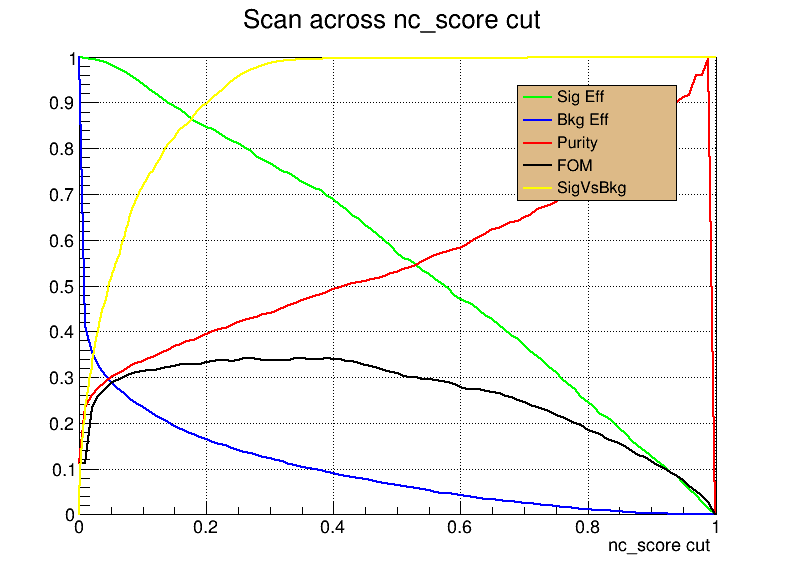

In [52]:
c.Draw()
print("Max Figure-of-merit: {}, at cut value: {}".format(nc_max_fom, nc_max_fom_cut))

In [53]:
# Generate efficiency and purity histograms using the maximised FOM
nuelCCAll = b_ev[b_ev.t_full_cat == 0]
nuelCCSel = b_ev[(b_ev.t_full_cat == 0) & (b_ev.base_cut == 0) & (b_ev.cosmic_cut == 0) & (b_ev.nuel_score > nuel_max_fom_cut)]
nuelCCAll_h = ROOT.TH1F("nuelCCAll", "", 10, 1000, 6000)
nuelCCSel_h = ROOT.TH1F("nuelCCSel", "", 10, 1000, 6000)
nuelCCAll_h.Sumw2()
nuelCCSel_h.Sumw2()
fill_hist(nuelCCAll_h, nuelCCAll['t_nuEnergy'].to_numpy(), nuelCCAll['weight'].to_numpy())
fill_hist(nuelCCSel_h, nuelCCSel['t_nuEnergy'].to_numpy(), nuelCCSel['weight'].to_numpy())
nuelCCEff = ROOT.TGraphAsymmErrors(nuelCCSel_h, nuelCCAll_h, "n")

numuCCAll = b_ev[b_ev.t_full_cat == 1]
numuCCSel = b_ev[(b_ev.t_full_cat == 1) & (b_ev.base_cut == 0) & (b_ev.cosmic_cut == 0) & (b_ev.nuel_score > nuel_max_fom_cut)]
numuCCAll_h = ROOT.TH1F("numuCCAll", "", 10, 1000, 6000)
numuCCSel_h = ROOT.TH1F("numuCCSel", "", 10, 1000, 6000)
numuCCAll_h.Sumw2()
numuCCSel_h.Sumw2()
fill_hist(numuCCAll_h, numuCCAll['t_nuEnergy'].to_numpy(), numuCCAll['weight'].to_numpy())
fill_hist(numuCCSel_h, numuCCSel['t_nuEnergy'].to_numpy(), numuCCSel['weight'].to_numpy())
numuCCEff = ROOT.TGraphAsymmErrors(numuCCSel_h, numuCCAll_h, "n")

ncAll = b_ev[b_ev.t_full_cat == 2]
ncSel = b_ev[(b_ev.t_full_cat == 2) & (b_ev.base_cut == 0) & (b_ev.cosmic_cut == 0) & (b_ev.nuel_score > nuel_max_fom_cut)]
ncAll_h = ROOT.TH1F("ncAll", "", 10, 1000, 6000)
ncSel_h = ROOT.TH1F("ncSel", "", 10, 1000, 6000)
ncAll_h.Sumw2()
ncSel_h.Sumw2()
fill_hist(ncAll_h, ncAll['t_nuEnergy'].to_numpy(), ncAll['weight'].to_numpy())
fill_hist(ncSel_h, ncSel['t_nuEnergy'].to_numpy(), ncSel['weight'].to_numpy())
ncEff = ROOT.TGraphAsymmErrors(ncSel_h, ncAll_h, "n")

cosmicAll = b_ev[b_ev.t_full_cat == 3]
cosmicSel = b_ev[(b_ev.t_full_cat == 3) & (b_ev.base_cut == 0) & (b_ev.cosmic_cut == 0) & (b_ev.nuel_score > nuel_max_fom_cut)]
cosmicAll_h = ROOT.TH1F("cosmicAll", "", 10, 1000, 6000)
cosmicSel_h = ROOT.TH1F("cosmicSel", "", 10, 1000, 6000)
cosmicAll_h.Sumw2()
cosmicSel_h.Sumw2()
fill_hist(cosmicAll_h, cosmicAll['t_nuEnergy'].to_numpy(), cosmicAll['weight'].to_numpy())
fill_hist(cosmicSel_h, cosmicSel['t_nuEnergy'].to_numpy(), cosmicSel['weight'].to_numpy())
cosmicEff = ROOT.TGraphAsymmErrors(cosmicSel_h, cosmicAll_h, "n")

signal = b_ev[(b_ev.t_full_cat == 0) & (b_ev.base_cut == 0) & (b_ev.cosmic_cut == 0) & (b_ev.nuel_score > nuel_max_fom_cut)]
total = b_ev[(b_ev.base_cut == 0) & (b_ev.cosmic_cut == 0) & (b_ev.nuel_score > nuel_max_fom_cut)]
signal_h = ROOT.TH1F("signal", "", 10, 1000, 6000)
total_h = ROOT.TH1F("total", "", 10, 1000, 6000)
signal_h.Sumw2()
total_h.Sumw2()
fill_hist(signal_h, signal['t_nuEnergy'].to_numpy(), signal['weight'].to_numpy())
fill_hist(total_h, total['t_nuEnergy'].to_numpy(), total['weight'].to_numpy())
purity = ROOT.TGraphAsymmErrors(signal_h, total_h, "n")

Warning in <TGraphAsymmErrors::Divide>: Number of graph points is different than histogram bins - 10 points have been skipped


In [54]:
# Make a efficiency and purity plot as a function of neutrino energy
eff_c = ROOT.TCanvas("eff_c", "", 800, 600)
eff_c.cd()

hempty = ROOT.TH2F("hempty", ";Neutrino Energy (MeV); Efficiency or Purity", 1, 1000, 6000, 10, 0, 1)
hempty.GetXaxis().SetTitleSize(0.06)  
hempty.GetYaxis().SetTitleSize(0.06) 
hempty.GetXaxis().CenterTitle()
hempty.GetXaxis().SetTitleOffset(0.8)  
hempty.GetYaxis().SetTitleOffset(0.8) 
hempty.GetYaxis().CenterTitle()
hempty.GetXaxis().SetLabelSize(0.05)    
hempty.GetYaxis().SetLabelSize(0.05)
hempty.Draw()

nuelCCEff.SetLineColor(ROOT.kGreen)     
nuelCCEff.SetLineWidth(2)
nuelCCEff.SetMarkerSize(1.2)    
nuelCCEff.SetMarkerStyle(20)
nuelCCEff.SetMarkerColor(ROOT.kGreen)
nuelCCEff.Draw("sameP")

numuCCEff.SetLineColor(ROOT.kBlue)     
numuCCEff.SetLineWidth(2)
numuCCEff.SetMarkerSize(1.2)    
numuCCEff.SetMarkerStyle(20)
numuCCEff.SetMarkerColor(ROOT.kBlue)
numuCCEff.Draw("sameP")

ncEff.SetLineColor(ROOT.kRed)     
ncEff.SetLineWidth(2)
ncEff.SetMarkerSize(1.2)    
ncEff.SetMarkerStyle(20)
ncEff.SetMarkerColor(ROOT.kRed)
ncEff.Draw("sameP")

cosmicEff.SetLineColor(ROOT.kBlack)     
cosmicEff.SetLineWidth(2)
cosmicEff.SetMarkerSize(1.2)    
cosmicEff.SetMarkerStyle(20)
cosmicEff.SetMarkerColor(ROOT.kBlack)
cosmicEff.Draw("sameP")

purity.SetLineColor(ROOT.kYellow)     
purity.SetLineWidth(2)
purity.SetMarkerSize(1.2)    
purity.SetMarkerStyle(20)
purity.SetMarkerColor(ROOT.kYellow)
purity.Draw("sameP")

leg = ROOT.TLegend(0.15, 0.65, 0.35, 0.85)
leg.AddEntry(nuelCCEff, "#nu_{e} CC Eff", "P")
leg.AddEntry(numuCCEff, "#nu_{#mu} CC Eff", "P")
leg.AddEntry(ncEff, "NC Eff", "P")
leg.AddEntry(cosmicEff, "Cosmic Eff", "P")
leg.AddEntry(purity, "#nu_{e} CC Purity", "P")
leg.SetTextSize(0.03)
leg.SetTextFont(42)
leg.SetFillColor(42)
leg.SetFillStyle(1001)
leg.Draw()
eff_c.Update()

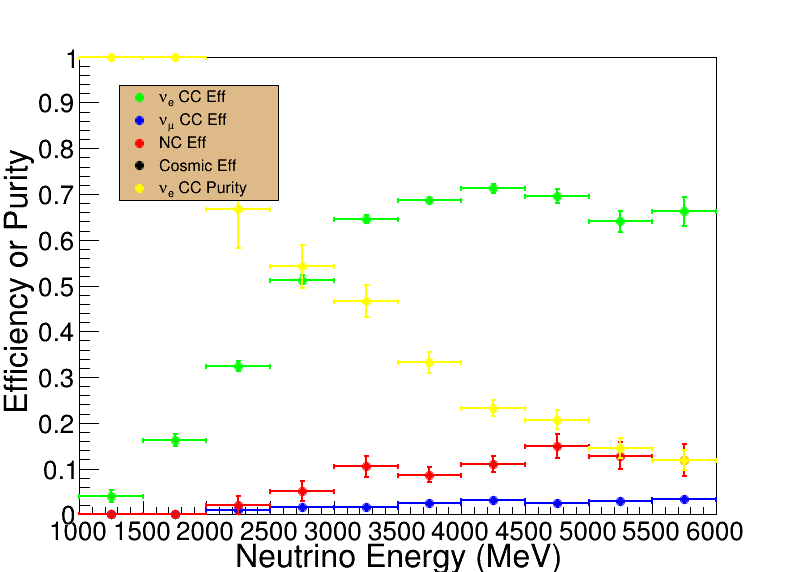

In [55]:
eff_c.Draw()

In [56]:
# Plot a confusion matrix for events that pass the cut in the beam sample
def pred_classifier(event):
    combined_values = [event['nuel_score'], event['numu_score'], event['nc_score']]
    return np.asarray(combined_values).argmax()
    
b_selection = b_eval.events[(b_eval.events.base_cut == False) & (b_eval.events.cosmic_cut == False)]
b_selection = b_selection[b_selection.t_full_cat != 3]
b_selection['pred_cat_combined'] = b_selection.apply(pred_classifier, axis=1)

full_cat_labels = ["EL-CC", "MU-CC", "NC"]
b_matrix_full_cat = confusion_matrix(b_selection["t_full_cat"], b_selection["pred_cat_combined"], normalize='true')
b_matrix_full_cat = np.rot90(b_matrix_full_cat, 1)
b_matrix_full_cat = pd.DataFrame(b_matrix_full_cat, index=full_cat_labels[::-1], columns=full_cat_labels)

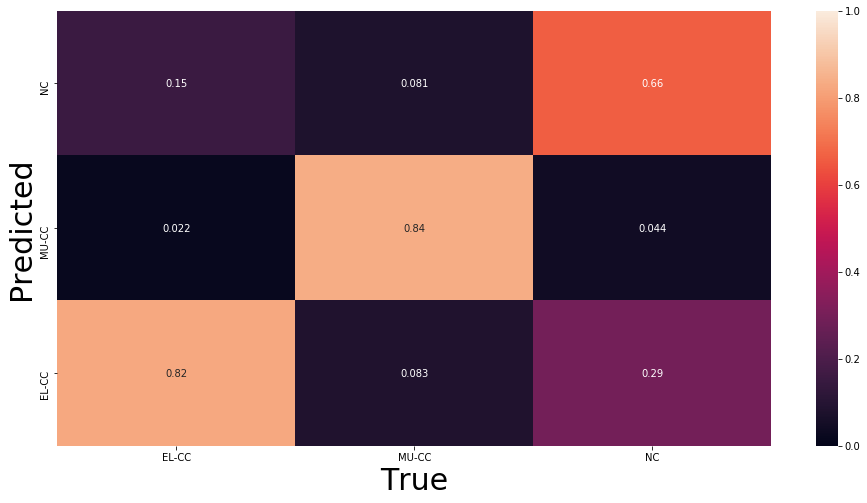

In [73]:
plt.figure(figsize=(16,8))
sns.heatmap(b_matrix_full_cat, annot=True, vmin=0.0, vmax=1.0); plt.xlabel('True', fontsize = 30); plt.ylabel('Predicted', fontsize = 30)
plt.show() # Fully combined category confusion matrix for beam sample

In [58]:
# Plot a confusion matrix for events that pass the cut in the uniform sample
u_selection = u_eval.events[(u_eval.events.base_cut == False) & (u_eval.events.cosmic_cut == False)]
u_selection = u_selection[u_selection.t_full_cat != 3]
u_selection['pred_cat_combined'] = u_selection.apply(pred_classifier, axis=1)

u_matrix_full_cat = confusion_matrix(u_selection["t_full_cat"], u_selection["pred_cat_combined"], normalize='true')
u_matrix_full_cat = np.rot90(u_matrix_full_cat, 1)
u_matrix_full_cat = pd.DataFrame(u_matrix_full_cat, index=full_cat_labels[::-1], columns=full_cat_labels)

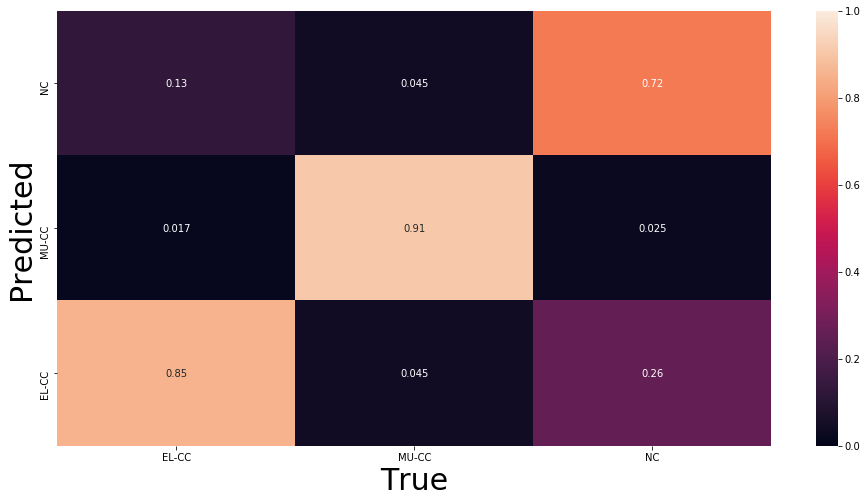

In [74]:
plt.figure(figsize=(16,8))
sns.heatmap(u_matrix_full_cat, annot=True, vmin=0.0, vmax=1.0); plt.xlabel('True', fontsize = 30); plt.ylabel('Predicted', fontsize = 30)
plt.show() # Fully combined category confusion matrix for uniform sample

In [60]:
# Print a Sklearn classification report
print(classification_report(b_selection["t_full_cat"], b_selection["pred_cat_combined"], target_names=full_cat_labels))
print(classification_report(u_selection["t_full_cat"], u_selection["pred_cat_combined"], target_names=full_cat_labels))

              precision    recall  f1-score   support

       EL-CC       0.85      0.82      0.84     16049
       MU-CC       0.96      0.84      0.89     15348
          NC       0.38      0.66      0.48      3411

    accuracy                           0.81     34808
   macro avg       0.73      0.77      0.74     34808
weighted avg       0.85      0.81      0.83     34808

              precision    recall  f1-score   support

       EL-CC       0.78      0.85      0.81     13788
       MU-CC       0.96      0.91      0.93     13167
          NC       0.77      0.72      0.74     10843

    accuracy                           0.83     37798
   macro avg       0.83      0.83      0.83     37798
weighted avg       0.84      0.83      0.84     37798



In [61]:
def all_cat_classifier(event):
    combined_values = [event[('b_out_' + str(i))] for i in range(b_eval.b_model.categories)]
    return np.asarray(combined_values).argmax()

b_selection['pred_all_cat'] = b_selection.apply(all_cat_classifier, axis=1)
b_matrix_cat = confusion_matrix(b_selection[b_eval.b_model.cat], b_selection["pred_all_cat"], normalize='true')
b_matrix_cat = np.rot90(b_matrix_cat, 1)
b_matrix_cat = pd.DataFrame(b_matrix_cat, index=b_eval.b_model.labels[::-1], columns=b_eval.b_model.labels)

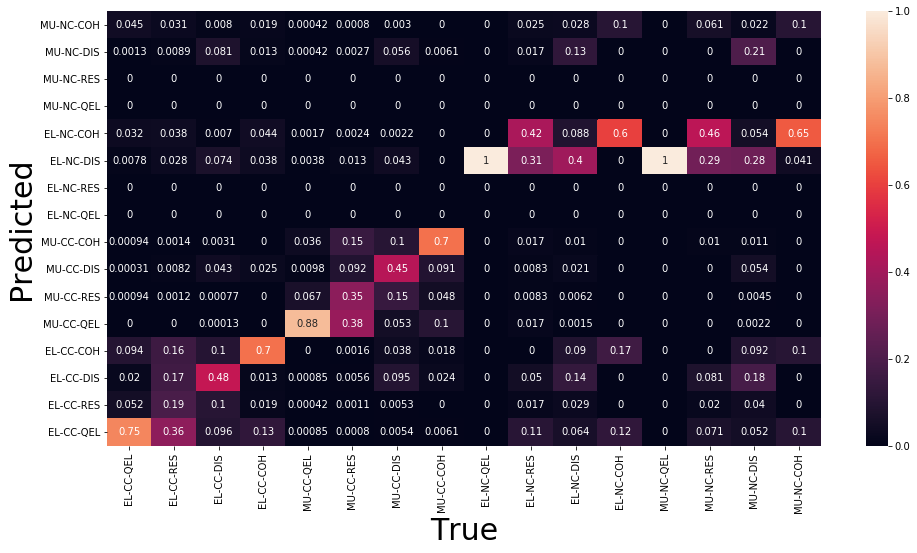

In [75]:
plt.figure(figsize=(16,8))
sns.heatmap(b_matrix_cat, annot=True, vmin=0.0, vmax=1.0); plt.xlabel('True', fontsize = 30); plt.ylabel('Predicted', fontsize = 30)
plt.show() # All category confusion matrix for beam sample

In [63]:
u_selection['pred_all_cat'] = u_selection.apply(all_cat_classifier, axis=1)
u_matrix_cat = confusion_matrix(u_selection[u_eval.b_model.cat], u_selection["pred_all_cat"], normalize='true')
u_matrix_cat = np.rot90(u_matrix_cat, 1)
u_matrix_cat = pd.DataFrame(u_matrix_cat, index=u_eval.b_model.labels[::-1], columns=u_eval.b_model.labels)

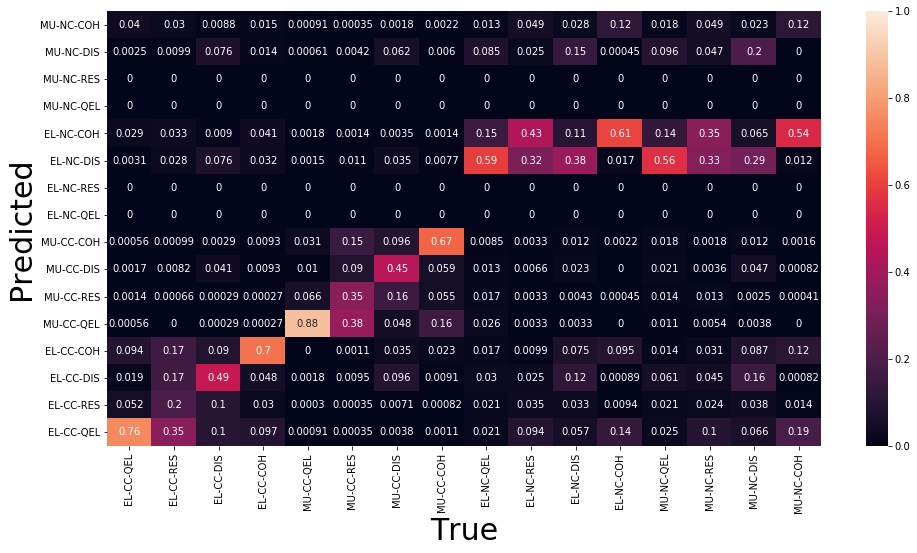

In [76]:
plt.figure(figsize=(16,8))
sns.heatmap(u_matrix_cat, annot=True, vmin=0.0, vmax=1.0); plt.xlabel('True', fontsize = 30); plt.ylabel('Predicted', fontsize = 30)
plt.show() # All category confusion matrix for uniform sample

In [65]:
# Print a Sklearn classification report
print(classification_report(b_selection[b_eval.b_model.cat], b_selection["pred_all_cat"], target_names=b_eval.b_model.labels))
print(classification_report(u_selection[u_eval.b_model.cat], u_selection["pred_all_cat"], target_names=u_eval.b_model.labels))

              precision    recall  f1-score   support

   EL-CC-QEL       0.46      0.75      0.57      3199
   EL-CC-RES       0.45      0.19      0.27      4849
   EL-CC-DIS       0.62      0.48      0.54      7843
   EL-CC-COH       0.04      0.70      0.08       158
   MU-CC-QEL       0.52      0.88      0.65      2358
   MU-CC-RES       0.46      0.35      0.40      3740
   MU-CC-DIS       0.82      0.45      0.58      9085
   MU-CC-COH       0.07      0.70      0.12       165
   EL-NC-QEL       0.00      0.00      0.00         7
   EL-NC-RES       0.00      0.00      0.00       121
   EL-NC-DIS       0.23      0.40      0.29      1292
   EL-NC-COH       0.04      0.60      0.07        48
   MU-NC-QEL       0.00      0.00      0.00         3
   MU-NC-RES       0.00      0.00      0.00        99
   MU-NC-DIS       0.21      0.21      0.21      1792
   MU-NC-COH       0.01      0.10      0.02        49

    accuracy                           0.45     34808
   macro avg       0.25   

In [66]:
N = 1000
beam_data = []
for i in range(u_eval.b_model.categories):
    beam_data.append(u_eval.events[u_eval.events[u_eval.b_model.cat] == i][:N])
beam_data = pd.concat(beam_data)
beam_data = beam_data[['t_cat', 't_full_cat', 't_cosmic_cat', 't_nu_nc_cat', 't_nc_cat', 'b_dense']]
beam_data = beam_data.sample(frac=1).reset_index(drop=True)

# Remove dense output mean and scale to unit variance
beam_scaler = StandardScaler()  
beam_dense = np.stack(beam_data['b_dense'])
beam_dense = beam_scaler.fit_transform(beam_dense)  

colors = ["#004d00", "#009900", "#00e600", "#33ff33", 
          "#00004d", "#0000b3", "#1a1aff", "#8080ff", 
          "#660000", "#cc0000", "#ff3333", "#ff9999",
          "#660000", "#cc0000", "#ff3333", "#ff9999"]

In [67]:
beam_pca = PCA(n_components=3)
beam_pca_result = beam_pca.fit_transform(beam_dense)
beam_pca_df = pd.DataFrame(beam_pca_result)
beam_data['beam-pca-0'] = beam_pca_df[0]
beam_data['beam-pca-1'] = beam_pca_df[1]
beam_data['beam-pca-2'] = beam_pca_df[2]
print('Explained variation per principal component: {}'.format(beam_pca.explained_variance_ratio_))

Explained variation per principal component: [0.14018258 0.12312143 0.10390446]


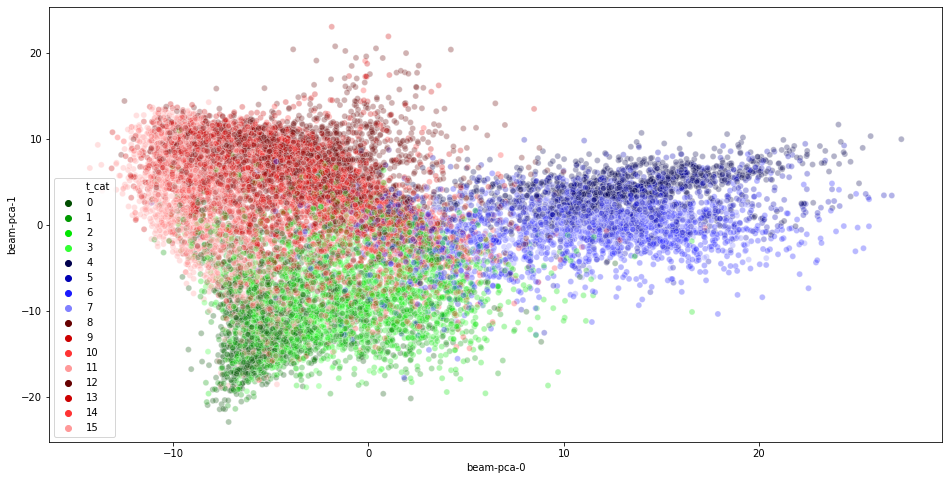

In [68]:
plt.figure(figsize=(16,8))
sns.scatterplot(x="beam-pca-0", y="beam-pca-1", hue=u_eval.b_model.cat, palette=sns.color_palette(colors), data=beam_data, legend="full", alpha=0.3)
plt.show()

In [69]:
beam_tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
beam_tsne_results = beam_tsne.fit_transform(beam_dense)
beam_tsne_df = pd.DataFrame(beam_tsne_results)
beam_data['beam-tsne-0'] = beam_tsne_df[0]
beam_data['beam-tsne-1'] = beam_tsne_df[1]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 16000 samples in 2.594s...
[t-SNE] Computed neighbors for 16000 samples in 362.146s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16000
[t-SNE] Computed conditional probabilities for sample 2000 / 16000
[t-SNE] Computed conditional probabilities for sample 3000 / 16000
[t-SNE] Computed conditional probabilities for sample 4000 / 16000
[t-SNE] Computed conditional probabilities for sample 5000 / 16000
[t-SNE] Computed conditional probabilities for sample 6000 / 16000
[t-SNE] Computed conditional probabilities for sample 7000 / 16000
[t-SNE] Computed conditional probabilities for sample 8000 / 16000
[t-SNE] Computed conditional probabilities for sample 9000 / 16000
[t-SNE] Computed conditional probabilities for sample 10000 / 16000
[t-SNE] Computed conditional probabilities for sample 11000 / 16000
[t-SNE] Computed conditional probabilities for sample 12000 / 16000
[t-SNE] Computed conditional probabilities for 

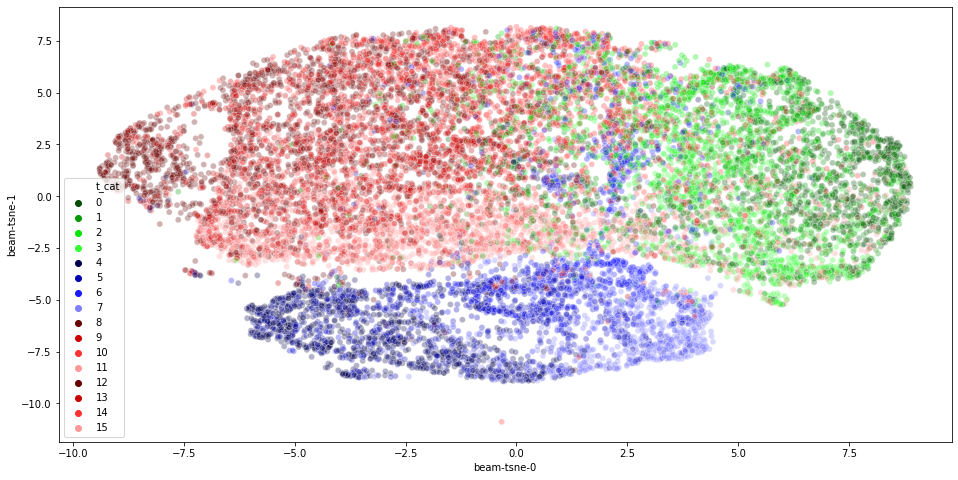

In [70]:
plt.figure(figsize=(16,8))
sns.scatterplot(x="beam-tsne-0", y="beam-tsne-1", hue=u_eval.b_model.cat, palette=sns.color_palette(colors), data=beam_data, legend="full", alpha=0.3)
plt.show()

In [78]:
# Look at the NC events that passed all the cuts
nc_passed_events = b_eval.events[(b_eval.events.base_cut == False) & 
                                 (b_eval.events.cosmic_cut == False) &
                                 (b_eval.events.nuel_score >= nuel_max_fom_cut) &
                                 (b_eval.events.t_full_cat == 2)]
nc_events = b_eval.events[(b_eval.events.base_cut == False) & 
                          (b_eval.events.cosmic_cut == False) &
                          (b_eval.events.t_full_cat == 2)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f359c7534d0>]],
      dtype=object)

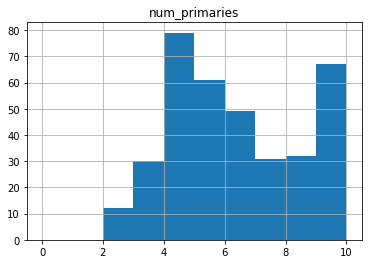

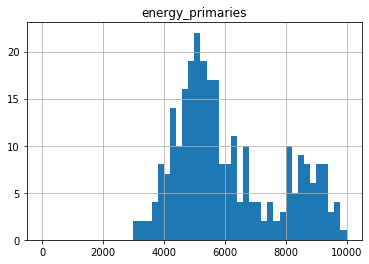

In [79]:
def num_primaries(event):
    num = 0
    for primary in event['t_p_pdgs']:
        if primary != -999:
            num += 1
    return num

def energy_primaries(event):
    total = 0.0
    for energy in event['t_p_energies']:
        if energy != -999:
            total += energy
    return total

nc_passed_events['num_primaries'] = nc_passed_events.apply(num_primaries, axis=1)
nc_passed_events['energy_primaries'] = nc_passed_events.apply(energy_primaries, axis=1)
nc_passed_events.hist(column="num_primaries", range=[0,10], bins=10)
nc_passed_events.hist(column="energy_primaries", range=[0,10000], bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f34d4107f50>]],
      dtype=object)

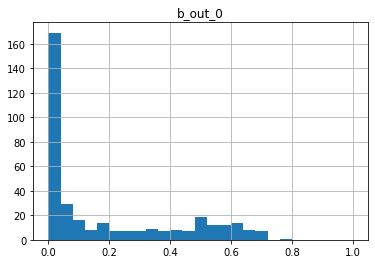

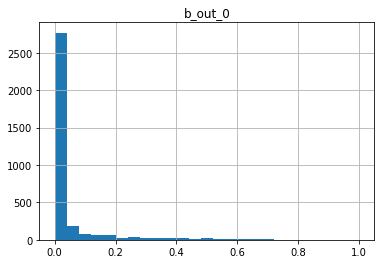

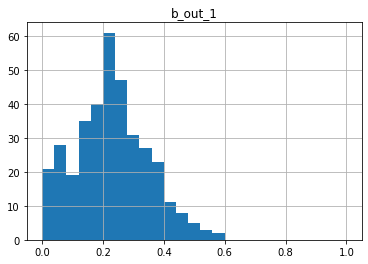

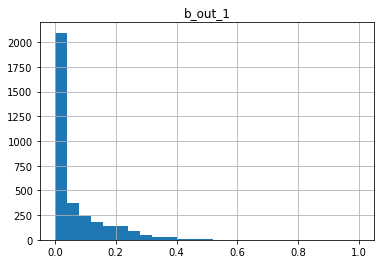

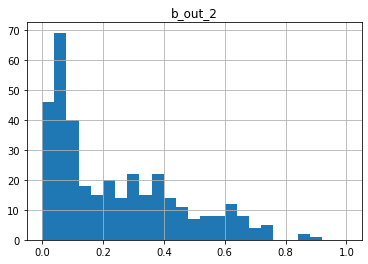

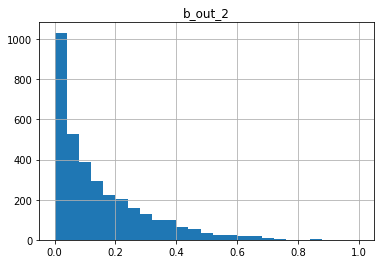

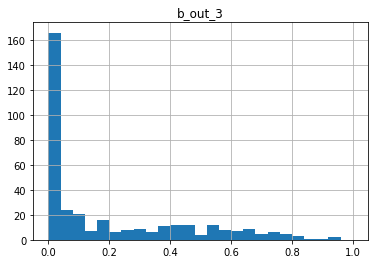

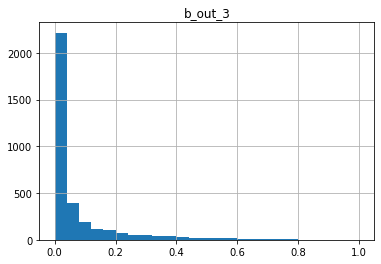

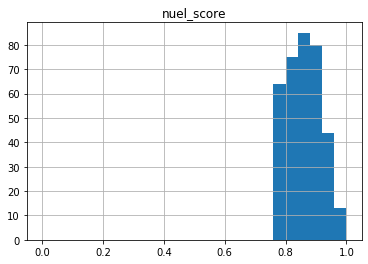

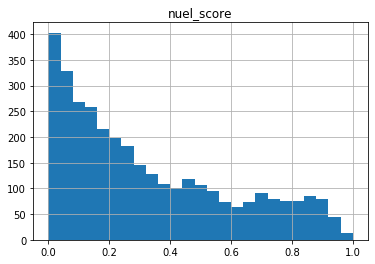

In [80]:
nc_passed_events.hist(column="b_out_0", range=[0,1], bins=25)
nc_events.hist(column="b_out_0", range=[0,1], bins=25)
nc_passed_events.hist(column="b_out_1", range=[0,1], bins=25)
nc_events.hist(column="b_out_1", range=[0,1], bins=25)
nc_passed_events.hist(column="b_out_2", range=[0,1], bins=25)
nc_events.hist(column="b_out_2", range=[0,1], bins=25)
nc_passed_events.hist(column="b_out_3", range=[0,1], bins=25)
nc_events.hist(column="b_out_3", range=[0,1], bins=25)
nc_passed_events.hist(column="nuel_score", range=[0,1], bins=25)
nc_events.hist(column="nuel_score", range=[0,1], bins=25)

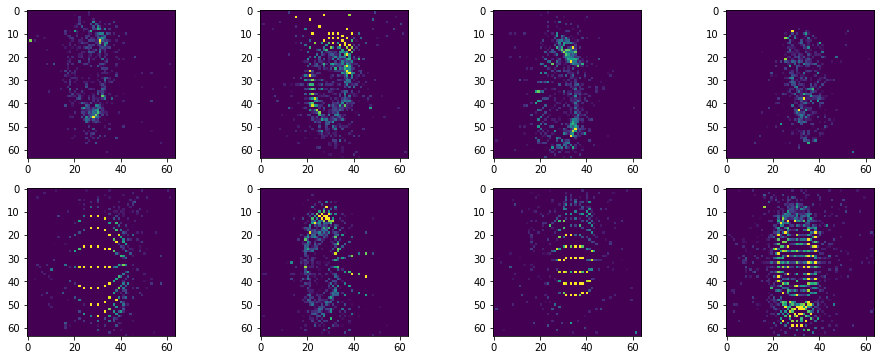

In [84]:
# Plot some example NC events that passed the cuts displaying their "charge_channel" 
fig=plt.figure(figsize=(16, 6))
columns, rows = 4, 2
for i in range(1, columns*rows +1):
    img = nc_passed_events['image_0'].values[i].reshape((64,64))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

## Save Plots to file

We save the output plots to a root file in the model output directory...

In [86]:
import os

output_name = os.path.join(b_eval.config.models.beam.dir, b_eval.config.models.beam.path, "output.root")
beam_output = ROOT.TFile(output_name, 'RECREATE')

b_loss_g.Write()
b_accuracy_g.Write()
b_val_loss_g.Write()
b_val_accuracy_g.Write()

for i in range(4):
    nuel_hists[i].Write()
    numu_hists[i].Write()
    nc_hists[i].Write()

nuel_eff_sig_g.Write()
nuel_eff_bkg_g.Write()
nuel_pur_g.Write()
nuel_fom_g.Write()
nuel_eff_vs_bkg_g.Write()

numu_eff_sig_g.Write()
numu_eff_bkg_g.Write()
numu_pur_g.Write()
numu_fom_g.Write()
numu_eff_vs_bkg_g.Write()

nc_eff_sig_g.Write()
nc_eff_bkg_g.Write()
nc_pur_g.Write()
nc_fom_g.Write()
nc_eff_vs_bkg_g.Write()

nuelCCEff.SetName("nuelCCEff")
nuelCCEff.Write()
numuCCEff.SetName("numuCCEff")
numuCCEff.Write()
ncEff.SetName("ncEff")
ncEff.Write()
cosmicEff.SetName("cosmicEff")
cosmicEff.Write()
purity.SetName("purity")
purity.Write()

beam_output.Close()

In [ ]:
'''
importlib.reload(chipscvn.explain)

inputs = {'image_0': evaluator.events['image_0'][0],
          'image_1': evaluator.events['image_1'][0],
          'image_2': evaluator.events['image_2'][0],
          'r_vtxX': evaluator.events['r_vtxX'][0],
          'r_vtxY': evaluator.events['r_vtxY'][0],
          'r_vtxZ': evaluator.events['r_vtxZ'][0],
          'r_dirTheta': evaluator.events['r_dirTheta'][0],
          'r_dirPhi': evaluator.events['r_dirPhi'][0]}

label = evaluator.events[evaluator.b_model.cat][0]

cam = chipscvn.explain.GradCAM(evaluator.b_model.model, label, "conv_1_8")
heatmap = cam.compute_heatmap(inputs)
'''